In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import re
from collections import Counter

# VEST OH 2020
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Ohio Secretary of State (https://www.sos.state.oh.us/elections/election-results-and-data/). 

#### Processing Part 1
The following counties include adjustments to account for corporate annexations that are not specified below by precinct: Adams, Athens, Butler, Franklin, Guernsey, Montgomery, Stark, Tuscarawas, Warren, Wayne.

#### Processing Part 2 (unclear whether this is for election results, shapefiles, or both)
The following additional revisions were made to match the 2020 precinct boundaries:

- **Athens:** Adjust Athens 4-4/4-5, Nelsonville 1/2/3/4
- **Brown:** Adjust Perry Twp South/Villages
- **Butler:** Adjust Hamilton 22/24, Oxford 6/11, Trenton 5/7, West Chester 28/39
- **Champaign:** Adjust Union N/S
- **Clark:** Align New Carlisle, Springfield precincts with county maps
- **Crawford:** Move eastern Polk Twp from Galion 1B to western Polk Twp
- **Cuyahoga:** Adjust Olmsted Twp D/F/H
- **Delaware:** Adjust Berlin C/Delaware 3-F
- **Fairfield:** Adjust Greenfield B/Lancaster 2-A, Pickerington F/Violet B/Violet C
- **Greene:** Adjust Bath 277/Fairborn 226/Xenia 351
- **Hamilton:** Adjust Cleves A/Whitewater A, Colerain BB/F
- **Knox:** Adjust Clinton A/Mount Vernon 1-B, Clinton B/Mount Vernon 2-A
- **Lake:** Adjust Painesville A/K
- **Medina:** Adjust Wadsworth City 1-D/Sharon D, Wadsworth City 2-D/Twp C
- **Richland:** Adjust Ontario 3/4
- **Stark:** Adjust Canton 8-C/Plain 6, Canton 6-A/Plain 12
- **Summit:** Adjust Coventry D/G, Hudson 1-B/3-C, Springfield F/J
- **Warren:** Adjust Mason City Z/Union A, South Lebanon A/B

#### Races
G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREGHAW - Howie Hawkins (Independent)  

### Shapefiles

#### Sources
Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program final release. Note that some VTDs were relabeled to match precinct names and/or precinct codes in the November 2020 general election returns.

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_oh_20 = gp.read_file("./raw-from-source/VEST/oh_2020/oh_2020.shp")

In [3]:
vest_oh_20.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

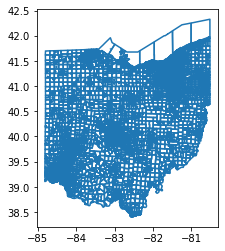

In [4]:
vest_oh_20.boundary.plot()

In [5]:
vest_oh_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry'],
      dtype='object')

### Create a FIPs dictionary for OH

In [6]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Ohio"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
oh_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Cleaned the `statewideresultsbyprecinct.xlsx` file by hand, and created `statewideresultsbyprecinct_clean.csv`. No modifications were made to the election results. Unnecessary tabs were removed and column names were renamed to match VEST's manually. 

In [7]:
#Load in clean SOS file
dem_elections_2020 = pd.read_excel("./raw-from-source/SOS/democratprecinctall.xlsx",sheet_name="Master")
rep_elections_2020 = pd.read_excel("./raw-from-source/SOS/republicanprecinct.xlsx",sheet_name="Master")
lib_elections_2020 = pd.read_excel("./raw-from-source/SOS/libertarianprecinctall.xlsx",sheet_name="Master")

In [8]:
dem_elections_2020.head()

March 17, 2020 Primary Election Official Canvass\n*Results for write-in (WI) candidates will not be available on election night.\n*Write-in candidates will be displayed with a (WI) designation and not party affiliation.\n*Precinct-level data is not available for write-in candidates. To view results for write-in candidates, download the Summary-level spreadsheet.  \
0                                        County Name                                                                                                                                                                                                                                                                                                                             
1                                              Total                                                                                                                                                                                                                                                                                                                             
2                                         Percentage                                                                                                                                                                                                                                                                                                                             
3                                              Adams                                                                                                                                                                                                                                                                                                                             
4                                              Adams                                                                                                                                                                                                                                                                                                                             

             Unnamed: 1     Unnamed: 2   Unnamed: 3    Unnamed: 4  \
0         Precinct Name  Precinct Code  Region Name  Media Market   
1                   NaN            NaN          NaN           NaN   
2                   NaN            NaN          NaN           NaN   
3      BRATTON TOWNSHIP            AAA    Southwest    Cincinnati   
4  BRUSH CREEK TOWNSHIP            AAB    Southwest    Cincinnati   

          Unnamed: 5    Unnamed: 6          Unnamed: 7 President (at-large)\n  \
0  Registered Voters  Total Voters  Turnout Percentage     Michael Bennet (D)   
1            7774767       1834465            0.235951                   2030   
2                NaN           NaN                 NaN               0.002271   
3                904           241            0.266593                      0   
4                749           183            0.244326                      0   

               Unnamed: 9  ... State Representative - District 88\n  \
0  Joseph R. Biden Jr (D)  ...                    Chris Liebold (D)   
1                  647284  ...                                 5473   
2                0.724128  ...                                    1   
3                      42  ...                                    0   
4                      36  ...                                    0   

  State Representative - District 89\n State Representative - District 91\n  \
0                    Alexis Miller (D)                  Scott M. Dailey (D)   
1                                 7769                                 3225   
2                                    1                                    1   
3                                    0                                    0   
4                                    0                   

In [9]:
def clean_oh_import(dataframe):
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col_name = dataframe.columns[index]
        col_name = col_name.replace("\n"," ")
        if "Unnamed" in col_name:
            corrected_col_names.append(corrected_col_names[index-1])
        else:
            corrected_col_names.append(col_name)
    dataframe.columns = corrected_col_names
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col = dataframe.columns[index]
        first_row = dataframe.iloc[0,index]
        if (index > 7):
            new_column_name = col + " " + first_row 
            corrected_col_names.append(new_column_name)
        else:
            corrected_col_names.append(first_row)
    dataframe.columns = corrected_col_names
    
    dataframe = dataframe.iloc[3:,]
    return dataframe

In [10]:
dem_elections_2020_clean = clean_oh_import(dem_elections_2020)
rep_elections_2020_clean = clean_oh_import(rep_elections_2020)
lib_elections_2020_clean = clean_oh_import(lib_elections_2020)

In [11]:
for val in [dem_elections_2020_clean,rep_elections_2020_clean,lib_elections_2020_clean]:
    print(val.shape)
    val["UNIQUE_ID"] = val["County Name"]+"-"+val["Precinct Code"]

(8933, 197)
(8933, 226)
(8933, 15)


<ipython-input-11-e60a347620bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["UNIQUE_ID"] = val["County Name"]+"-"+val["Precinct Code"]


In [12]:
col_check_1 = rep_elections_2020_clean["UNIQUE_ID"] == lib_elections_2020_clean["UNIQUE_ID"]
col_check_2 = lib_elections_2020_clean["UNIQUE_ID"] == dem_elections_2020_clean["UNIQUE_ID"]

In [13]:
rep_elections_2020_clean.columns

Index(['County Name', 'Precinct Name', 'Precinct Code', 'Region Name',
       'Media Market', 'Registered Voters', 'Total Voters',
       'Turnout Percentage', 'President (at-large)  Donald J. Trump (R)',
       'President (district) - District 01  Donald J. Trump (R)',
       ...
       'State Representative - District 92  Mark Johnson (R)',
       'State Representative - District 93  Jeff Halley (R)',
       'State Representative - District 93  Jason C. Stephens (R)',
       'State Representative - District 94  Jay Edwards (R)',
       'State Representative - District 95  Don Jones (R)',
       'State Representative - District 96  Ron Ferguson (R)',
       'State Representative - District 97  Adam Holmes (R)',
       'State Representative - District 98  Brett Hudson Hillyer (R)',
       'State Representative - District 99  Sarah E. Fowler (R)', 'UNIQUE_ID'],
      dtype='object', length=227)

In [14]:
rep_elections_2020_clean.drop(['County Name', 'Precinct Name', 'Precinct Code', 'Region Name','Media Market', 'Registered Voters','Total Voters','Turnout Percentage',"UNIQUE_ID"],inplace=True,axis=1)
lib_elections_2020_clean.drop(['County Name', 'Precinct Name', 'Precinct Code', 'Region Name','Media Market', 'Registered Voters','Total Voters','Turnout Percentage',"UNIQUE_ID"],inplace=True,axis=1)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [15]:
combined = pd.concat([dem_elections_2020_clean,rep_elections_2020_clean,lib_elections_2020_clean],axis=1)

In [16]:
elections_2020 = combined.copy(deep=True)

In [17]:
elections_2020.drop("UNIQUE_ID", axis=1 , inplace=True)

In [18]:
#Map to the correct FIP
elections_2020["COUNTYFP"]=elections_2020["County Name"].map(oh_fips_dict).fillna(elections_2020["County Name"])

#Print out the FIPS to make sure they all are in the correct format
elections_2020["COUNTYFP"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '055', '057', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111', '113', '115', '117', '119', '121', '123', '125',
       '127', '129', '131', '133', '135', '137', '139', '141', '143',
       '145', '147', '149', '151', '153', '155', '157', '159', '161',
       '163', '165', '167', '169', '171', '173', '175'], dtype=object)

In [19]:
filter_out_cols = [i for i in elections_2020.columns if ("Judge of the Court of Appeals - District" in i or "Member of the State Board of Education - District" in i or "WI" in i)]


In [20]:
elections_2020 = elections_2020[[i for i in elections_2020.columns if i not in filter_out_cols]]

## Look into split precincts

In [21]:
def get_level_dist(column_name):
    if "Representative to Congress" in column_name:
        level = "CON"
    elif "State Senator" in column_name:
        level = "SU"
    elif "State Representative" in column_name:
        level = "SL"
    else:
        raise ValueError
    return_val = re.findall("District \S{2}",column_name)    
    if (len(return_val)!=0):
        dist = return_val[0].split(" ")[1]
    else:
        raise ValueError
    return level,dist

In [22]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one

In [23]:
for col in elections_2020[[i for i in elections_2020.columns if "President (district)" in i]]:
    print(col)
    print(sum(elections_2020[[i for i in elections_2020.columns if "President" in i]][col]))

President (district) - District 01  Donald J. Trump (R)
45125
President (district) - District 02  Donald J. Trump (R)
52981
President (district) - District 03  Donald J. Trump (R)
12971
President (district) - District 04  Donald J. Trump (R)
63283
President (district) - District 05  Donald J. Trump (R)
56297
President (district) - District 06  Donald J. Trump (R)
62299
President (district) - District 07  Donald J. Trump (R)
54886
President (district) - District 08  Donald J. Trump (R)
56470
President (district) - District 09  Donald J. Trump (R)
18095
President (district) - District 10  Donald J. Trump (R)
47061
President (district) - District 11  Donald J. Trump (R)
10116
President (district) - District 12  Donald J. Trump (R)
56368
President (district) - District 13  Donald J. Trump (R)
29243
President (district) - District 14  Donald J. Trump (R)
49125
President (district) - District 15  Donald J. Trump (R)
43236
President (district) - District 16  Donald J. Trump (R)
43543


In [24]:
#Combine the republican presidential primary results into one column
elections_2020["President Donald J. Trump (R)"] = 0
for val in [i for i in elections_2020.columns if "President (district)" in i]:
    elections_2020["President Donald J. Trump (R)"] += elections_2020[val]

In [25]:
elections_2020.drop([i for i in elections_2020.columns if "President (district)" in i],axis=1,inplace=True)

In [26]:
district_cols = [i for i in elections_2020.columns if "District" in i]
elections_2020_districts = elections_2020[['COUNTYFP','Precinct Name','Precinct Code']+district_cols]

In [27]:
district_cols

['Representative to Congress - District 01  Nikki Foster (D)',
 'Representative to Congress - District 01  Kate Schroder (D)',
 'Representative to Congress - District 02  Jaime M. Castle (D)',
 'Representative to Congress - District 03  Joyce Beatty (D)',
 'Representative to Congress - District 03  Morgan Harper (D)',
 'Representative to Congress - District 04  Shannon M. Freshour (D)',
 'Representative to Congress - District 04  Mike Larsen (D)',
 'Representative to Congress - District 04  Jeffrey A. Sites (D)',
 'Representative to Congress - District 05  M. Xavier Carrigan (D)',
 'Representative to Congress - District 05  Gene Redinger (D)',
 'Representative to Congress - District 05  Nick Rubando (D)',
 'Representative to Congress - District 06  Shawna Roberts (D)',
 'Representative to Congress - District 08  Vanessa Enoch (D)',
 'Representative to Congress - District 08  Matt Guyette (D)',
 'Representative to Congress - District 09  Marcy Kaptur (D)',
 'Representative to Congress -

In [28]:
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in elections_2020_districts.iterrows():
    precinct_list = []
    for contest in district_cols:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["COUNTYFP"]+"-"+row["Precinct Code"]]=is_split
    precinct_mapping_dict[row["COUNTYFP"]+"-"+row["Precinct Code"]]=precinct_list

In [29]:
split_precincts_list

{'011-AAR': {'SL': ['84', '82']},
 '017-ACG': {'SL': ['53', '51']},
 '017-AIF': {'SL': ['53', '51']},
 '035-AEI': {'CON': ['09', '16']},
 '035-AHU': {'SL': ['09', '12']},
 '035-ALT': {'SL': ['09', '11']},
 '035-AWR': {'SL': ['08', '10']},
 '035-AZU': {'SL': ['10', '13']},
 '035-BBR': {'SL': ['10', '15']},
 '035-BCI': {'SL': ['13', '15']},
 '035-BCZ': {'SL': ['10', '15']},
 '035-BEH': {'CON': ['09', '11']},
 '035-BFB': {'CON': ['09', '11']},
 '041-AEH': {'SL': ['67', '68']},
 '041-AEM': {'SL': ['67', '68']},
 '043-ACF': {'CON': ['04', '09']},
 '045-ACF': {'SL': ['77', '78']},
 '047-AAU': {'CON': ['10', '15']},
 '047-ABK': {'CON': ['10', '15']},
 '049-AAO': {'SL': ['17', '18']},
 '049-AAS': {'CON': ['03', '15']},
 '049-ABL': {'SL': ['18', '25']},
 '049-ABX': {'CON': ['03', '15']},
 '049-ABZ': {'CON': ['03', '15']},
 '049-ACD': {'CON': ['03', '15']},
 '049-ADF': {'SL': ['22', '24']},
 '049-ADJ': {'CON': ['03', '12']},
 '049-ADX': {'CON': ['03', '12']},
 '049-AEB': {'CON': ['03', '12']},
 

In [30]:
precinct_mapping_dict

{'001-AAA': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAB': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAD': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAE': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAG': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAI': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAK': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAN': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAP': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAR': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAS': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAT': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAU': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAW': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAY': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAZ': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-ABA': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-ABC': [('CON', '02'), ('S

## Rename the columns

In [31]:
list(elections_2020.columns)

['County Name',
 'Precinct Name',
 'Precinct Code',
 'Region Name',
 'Media Market',
 'Registered Voters',
 'Total Voters',
 'Turnout Percentage',
 'President (at-large)  Michael Bennet (D)',
 'President (at-large)  Joseph R. Biden Jr (D)',
 'President (at-large)  Michael R.  Bloomberg (D)',
 'President (at-large)  Pete Buttigieg (D)',
 'President (at-large)  Tulsi Gabbard (D)',
 'President (at-large)  Amy  Klobuchar (D)',
 'President (at-large)  Deval Patrick (D)',
 'President (at-large)  Bernie Sanders (D)',
 'President (at-large)  Tom Steyer (D)',
 'President (at-large)  Elizabeth Warren (D)',
 'Representative to Congress - District 01  Nikki Foster (D)',
 'Representative to Congress - District 01  Kate Schroder (D)',
 'Representative to Congress - District 02  Jaime M. Castle (D)',
 'Representative to Congress - District 03  Joyce Beatty (D)',
 'Representative to Congress - District 03  Morgan Harper (D)',
 'Representative to Congress - District 04  Shannon M. Freshour (D)',
 'Repr

## Rename Columns

In [32]:
elections_2020.columns

keep_names = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','Ballots Counted','Official Voter Turnout','Total Voters','Turnout Percentage','COUNTYFP','UNIQUE_ID']

In [33]:
def get_race(contest):
    if "Justice of the Supreme Court" in contest:
        level = "SSC"
        if "Kennedy" in contest or "O'Donnell" in contest:
            level = "SSCK"
        else:
            level = "SSCF"
    elif "President" in contest:
        level = "PRE"
    elif ("Representative to Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]
    else:
          raise ValueError
    return level

In [34]:
def get_party(contest):
    if contest == "State Representative - District 30  Tom Roll":
        return "I"
    if "Justice of the Supreme Court Term" in contest:
        if "Sharon L. Kennedy" in contest:
            return "R"
        elif "John P. O'Donnell" in contest:
            return "D"
        elif "Jennifer Brunner" in contest:
            return "D"
        elif "Judi French" in contest:
            return "R"
        else:
            print(contest)
            raise ValueError
    return_val = re.findall("\(\S\)",contest)   
    if (len(return_val)!=0):
        party = return_val[0][1]
        return party
    else:
        print(contest)
        raise ValueError

In [35]:
def get_name(contest):
    contest = contest.upper()
    contest = contest.replace("'","")
    if ("(") in contest.split(" ")[-1]:
        second_to_last = contest.split(" ")[-2]
        #second_to_last = second_to_last.replace("'","")
        if second_to_last in ["JR","III"]:
            third_to_last = contest.split(" ")[-3]
            #third_to_last = third_to_last.replace("'","")
            return third_to_last[0:3]
        else:
            return second_to_last[0:3]
    else:
        return contest.split(" ")[-1][0:3] 

# TO DO: Ask about that second category of Trump votes

In [36]:
elections_2020.drop('President Donald J. Trump (R)',axis=1,inplace=True)

In [37]:
contest_name_change_dict = {}
for contest in elections_2020.columns:
    if contest  not in keep_names or "President" in contest:
        contest_name_change_dict[contest] = "P"+get_race(contest)+get_party(contest)+get_name(contest)

In [38]:
contest_name_change_dict

{'President (at-large)  Michael Bennet (D)': 'PPREDBEN',
 'President (at-large)  Joseph R. Biden Jr (D)': 'PPREDBID',
 'President (at-large)  Michael R.  Bloomberg (D)': 'PPREDBLO',
 'President (at-large)  Pete Buttigieg (D)': 'PPREDBUT',
 'President (at-large)  Tulsi Gabbard (D)': 'PPREDGAB',
 'President (at-large)  Amy  Klobuchar (D)': 'PPREDKLO',
 'President (at-large)  Deval Patrick (D)': 'PPREDPAT',
 'President (at-large)  Bernie Sanders (D)': 'PPREDSAN',
 'President (at-large)  Tom Steyer (D)': 'PPREDSTE',
 'President (at-large)  Elizabeth Warren (D)': 'PPREDWAR',
 'Representative to Congress - District 01  Nikki Foster (D)': 'PCON01DFOS',
 'Representative to Congress - District 01  Kate Schroder (D)': 'PCON01DSCH',
 'Representative to Congress - District 02  Jaime M. Castle (D)': 'PCON02DCAS',
 'Representative to Congress - District 03  Joyce Beatty (D)': 'PCON03DBEA',
 'Representative to Congress - District 03  Morgan Harper (D)': 'PCON03DHAR',
 'Representative to Congress - Di

In [39]:
elections_2020.rename(columns=contest_name_change_dict,inplace=True)

In [40]:
list(elections_2020.columns)

['County Name',
 'Precinct Name',
 'Precinct Code',
 'Region Name',
 'Media Market',
 'Registered Voters',
 'Total Voters',
 'Turnout Percentage',
 'PPREDBEN',
 'PPREDBID',
 'PPREDBLO',
 'PPREDBUT',
 'PPREDGAB',
 'PPREDKLO',
 'PPREDPAT',
 'PPREDSAN',
 'PPREDSTE',
 'PPREDWAR',
 'PCON01DFOS',
 'PCON01DSCH',
 'PCON02DCAS',
 'PCON03DBEA',
 'PCON03DHAR',
 'PCON04DFRE',
 'PCON04DLAR',
 'PCON04DSIT',
 'PCON05DCAR',
 'PCON05DRED',
 'PCON05DRUB',
 'PCON06DROB',
 'PCON08DENO',
 'PCON08DGUY',
 'PCON09DKAP',
 'PCON09DROS',
 'PCON10DMOY',
 'PCON10DTIM',
 'PCON11DBEL',
 'PCON11DFUD',
 'PCON11DHOO',
 'PCON11DSHA',
 'PCON12DBEL',
 'PCON12DSHE',
 'PCON13DRYA',
 'PCON14DMUE',
 'PCON15DKIL',
 'PCON15DNEW',
 'PCON16DGOD',
 'PCON16DKAR',
 'PSSCKDODO',
 'PSSCFDBRU',
 'PSU02DODO',
 'PSU02DSUB',
 'PSU04DWYE',
 'PSU06DFOG',
 'PSU06DGRI',
 'PSU08DBRO',
 'PSU10DBAL',
 'PSU12DPOL',
 'PSU14DOTT',
 'PSU16DBAI',
 'PSU16DDOU',
 'PSU16DLET',
 'PSU18DRAD',
 'PSU20DJOH',
 'PSU22DJOH',
 'PSU24DJAC',
 'PSU26DSWA',
 'PSU28

### Filter Down to Relevant Columns

In [41]:
keeper_columns = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','COUNTYFP']
state_house_contests = [i for i in list(elections_2020.columns) if "PSL" in i]

In [42]:
elections_2020 = elections_2020[keeper_columns+state_house_contests]

### Compare Precinct Totals

In [43]:
elections_2020["UNIQUE_ID"] = elections_2020["COUNTYFP"]+"-"+elections_2020["Precinct Code"]
vest_oh_20["UNIQUE_ID"] = vest_oh_20["COUNTYFP20"]+"-"+vest_oh_20["PRECINCT20"]

In [44]:
#Confirm unique IDs are unique
print(elections_2020["UNIQUE_ID"].value_counts(dropna=False))
print(vest_oh_20["UNIQUE_ID"].value_counts(dropna=False))

037-ABY    1
035-BGH    1
153-BCC    1
025-AEG    1
099-ARO    1
          ..
095-ANP    1
113-AFH    1
091-ABX    1
029-ADP    1
135-ABA    1
Name: UNIQUE_ID, Length: 8933, dtype: int64
037-ABY    1
099-ANK    1
043-ACT    1
045-ACI    1
049-AZV    1
          ..
025-AHX    1
061-ARU    1
061-BCK    1
035-CFT    1
135-ABA    1
Name: UNIQUE_ID, Length: 8941, dtype: int64


In [45]:
global attempt_one
attempt_one = pd.merge(vest_oh_20,elections_2020,how="outer",on="UNIQUE_ID",indicator=True)
print(attempt_one["_merge"].value_counts())

vest_only = attempt_one[attempt_one["_merge"]=="left_only"]
elections_only = attempt_one[attempt_one["_merge"]=="right_only"]

both          8933
left_only        8
right_only       0
Name: _merge, dtype: int64


In [46]:
#Confirm these are all zero-vote races
races =["UNIQUE_ID"]

for val in ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR','G20PREGHAW']:
    races.append(val)

print((vest_only[races]))

     UNIQUE_ID  G20PRERTRU  G20PREDBID  G20PRELJOR  G20PREGHAW
814    093-ZZZ           0           0           0           0
982    123-ZZZ           0           0           0           0
2924   095-ZZZ           0           0           0           0
3674   043-ZZZ           0           0           0           0
4389   085-ZZZ           0           0           0           0
4565   035-ZZZ           0           0           0           0
5357   133-ZZZ           0           0           0           0
7951   007-ZZZ           0           0           0           0


## Perform Splits

In [47]:
def return_sll_splits(split_dict):
    for val in split_dict.keys():
        if 'SLL' in val:
            return split_dict['SLL']

In [48]:
sll_splits_dict = {i:return_sll_splits(split_precincts_list[i]) for i in split_precincts_list.keys() if return_sll_splits(split_precincts_list[i]) != None }

In [49]:
sll_splits_dict

{}

#### Load in the shapefile

In [50]:
oh_sll_districts = gp.read_file("./raw-from-source/District_Shapefiles/cb_2018_39_sldl_500k/cb_2018_39_sldl_500k.shp")

In [51]:
oh_sll_districts = oh_sll_districts.to_crs(vest_oh_20.crs)
oh_sll_districts["SLDLST"] = oh_sll_districts["SLDLST"].str[1:3]

In [52]:
list(attempt_one.columns)

['STATEFP20',
 'COUNTYFP20',
 'VTDST20',
 'PRECINCT20',
 'GEOID20',
 'NAME20',
 'G20PRERTRU',
 'G20PREDBID',
 'G20PRELJOR',
 'G20PREGHAW',
 'geometry',
 'UNIQUE_ID',
 'County Name',
 'Precinct Name',
 'Precinct Code',
 'Region Name',
 'Media Market',
 'Registered Voters',
 'COUNTYFP',
 'PSL01DTHE',
 'PSL03DJOH',
 'PSL05DWIN',
 'PSL06DROB',
 'PSL07DSWE',
 'PSL08DSMI',
 'PSL09DBOY',
 'PSL09DII',
 'PSL10DBUR',
 'PSL10DUPC',
 'PSL11DHOW',
 'PSL12DBRE',
 'PSL12DROS',
 'PSL13DSKI',
 'PSL14DSWE',
 'PSL15DCRO',
 'PSL16DROM',
 'PSL16DSMI',
 'PSL17DMIL',
 'PSL18DBOG',
 'PSL19DLIG',
 'PSL20DBRO',
 'PSL21DLIS',
 'PSL22DADH',
 'PSL22DLEL',
 'PSL23DDAY',
 'PSL24DRUS',
 'PSL25DJAM',
 'PSL25DJAR',
 'PSL25DJOS',
 'PSL25DMAK',
 'PSL25DNSI',
 'PSL26DCRA',
 'PSL27DBIT',
 'PSL28DMIR',
 'PSL31DKEL',
 'PSL32DING',
 'PSL32DWAS',
 'PSL33DDEN',
 'PSL33DGRA',
 'PSL34DSYK',
 'PSL35DGAL',
 'PSL36DHAR',
 'PSL36DSHA',
 'PSL37DWEI',
 'PSL38DCAM',
 'PSL39DBLA',
 'PSL39DHIC',
 'PSL39DJON',
 'PSL40DJAC',
 'PSL41DBER',
 

In [53]:
final_races = ['PSL01DTHE',
 'PSL03DJOH',
 'PSL05DWIN',
 'PSL06DROB',
 'PSL07DSWE',
 'PSL08DSMI',
 'PSL09DBOY',
 'PSL09DII',
 'PSL10DBUR',
 'PSL10DUPC',
 'PSL11DHOW',
 'PSL12DBRE',
 'PSL12DROS',
 'PSL13DSKI',
 'PSL14DSWE',
 'PSL15DCRO',
 'PSL16DROM',
 'PSL16DSMI',
 'PSL17DMIL',
 'PSL18DBOG',
 'PSL19DLIG',
 'PSL20DBRO',
 'PSL21DLIS',
 'PSL22DADH',
 'PSL22DLEL',
 'PSL23DDAY',
 'PSL24DRUS',
 'PSL25DJAM',
 'PSL25DJAR',
 'PSL25DJOS',
 'PSL25DMAK',
 'PSL25DNSI',
 'PSL26DCRA',
 'PSL27DBIT',
 'PSL28DMIR',
 'PSL31DKEL',
 'PSL32DING',
 'PSL32DWAS',
 'PSL33DDEN',
 'PSL33DGRA',
 'PSL34DSYK',
 'PSL35DGAL',
 'PSL36DHAR',
 'PSL36DSHA',
 'PSL37DWEI',
 'PSL38DCAM',
 'PSL39DBLA',
 'PSL39DHIC',
 'PSL39DJON',
 'PSL40DJAC',
 'PSL41DBER',
 'PSL43DCOX',
 'PSL45DSOB',
 'PSL46DSHE',
 'PSL47DLAR',
 'PSL49DWES',
 'PSL50DSIM',
 'PSL52DHOR',
 'PSL53DNOV',
 'PSL54DSHO',
 'PSL55DSTE',
 'PSL56DMIL',
 'PSL57DADK',
 'PSL58DHAG',
 'PSL59DSTA',
 'PSL60DTRO',
 'PSL61DDUD',
 'PSL62DROS',
 'PSL63DBLA',
 'PSL63DLAN',
 'PSL63DPRO',
 'PSL64DOBR',
 'PSL65DDAR',
 'PSL67DMOR',
 'PSL68DMOU',
 'PSL69DBEH',
 'PSL70DBAR',
 'PSL71DCAR',
 'PSL73DMCC',
 'PSL75DCLI',
 'PSL76DWES',
 'PSL77DWIL',
 'PSL78DOWE',
 'PSL79DRIC',
 'PSL84DMON',
 'PSL86DROB',
 'PSL87DBAR',
 'PSL88DLIE',
 'PSL89DMIL',
 'PSL91DDAI',
 'PSL92DWOR',
 'PSL94DONE',
 'PSL96DDIP',
 'PSL96DOLI',
 'PSL97DSWO',
 'PSL98DBEE',
 'PSL99DDAN',
 'PSL01RWET',
 'PSL01RWIG',
 'PSL02RJOH',
 'PSL02RMAR',
 'PSL03RGHA',
 'PSL04RCUP',
 'PSL05RGIN',
 'PSL06RHAR',
 'PSL06RHAW',
 'PSL07RPAT',
 'PSL09RRUS',
 'PSL14RMCM',
 'PSL15RKUS',
 'PSL16RGRE',
 'PSL17RHAS',
 'PSL17RRUT',
 'PSL18RPAC',
 'PSL19RFRE',
 'PSL20RBAE',
 'PSL21RCOO',
 'PSL22RSPE',
 'PSL23RLAN',
 'PSL24RMAN',
 'PSL25RBUR',
 'PSL27RBRI',
 'PSL28RMON',
 'PSL29RABR',
 'PSL30RSEI',
 'PSL33RHIL',
 'PSL34RTOD',
 'PSL35RSAR',
 'PSL36RYOU',
 'PSL37RBIG',
 'PSL38RROE',
 'PSL39RMUL',
 'PSL40RPLU',
 'PSL41RWHI',
 'PSL42RSTU',
 'PSL42RYOU',
 'PSL43RCRE',
 'PSL43RSMI',
 'PSL44RMCM',
 'PSL45RLOG',
 'PSL46RSAL',
 'PSL47RMER',
 'PSL48ROEL',
 'PSL49RHAA',
 'PSL50RSTO',
 'PSL51RCAR',
 'PSL52RGRO',
 'PSL52RWEL',
 'PSL53RGUI',
 'PSL53RHAL',
 'PSL53RMUL',
 'PSL54RZEL',
 'PSL55RMAN',
 'PSL56RLAC',
 'PSL57RSTE',
 'PSL58RSIM',
 'PSL59RMAN',
 'PSL60RPHI',
 'PSL61RCAL',
 'PSL62RLIP',
 'PSL63RLOY',
 'PSL64RYOD',
 'PSL65RBLE',
 'PSL65RDIL',
 'PSL65RSCH',
 'PSL66RBIR',
 'PSL66RFRE',
 'PSL66ROWE',
 'PSL67RJOR',
 'PSL68RCAR',
 'PSL69RRAY',
 'PSL70RKIC',
 'PSL70RROB',
 'PSL71RCLA',
 'PSL71RFRA',
 'PSL72RHOU',
 'PSL73RBRO',
 'PSL73RLAM',
 'PSL74RDEA',
 'PSL75RPAV',
 'PSL76RGRE',
 'PSL76RHAL',
 'PSL77RLAR',
 'PSL78RADA',
 'PSL78RMIT',
 'PSL78RSTE',
 'PSL79RKOE',
 'PSL80RPOW',
 'PSL81RHOO',
 'PSL82RRIE',
 'PSL83RCRO',
 'PSL84RMAN',
 'PSL85RVIT',
 'PSL86RRIC',
 'PSL87RMCC',
 'PSL88RCLI',
 'PSL88ROLL',
 'PSL88RTHO',
 'PSL89RSWE',
 'PSL90RBAL',
 'PSL91RWIL',
 'PSL92RJOH',
 'PSL93RHAL',
 'PSL93RSTE',
 'PSL94REDW',
 'PSL95RJON',
 'PSL96RFER',
 'PSL97RHOL',
 'PSL98RHIL',
 'PSL99RFOW',
 'PSL96LHER']

In [54]:
for val in final_races:
    attempt_one[val] = attempt_one[val].fillna(0)
    attempt_one[val] = attempt_one[val].astype(int)
    print(val, sum(attempt_one[val]))

PSL01DTHE 4253
PSL03DJOH 7243
PSL05DWIN 3911
PSL06DROB 10753
PSL07DSWE 8082
PSL08DSMI 11185
PSL09DBOY 16008
PSL09DII 2580
PSL10DBUR 1355
PSL10DUPC 6151
PSL11DHOW 5760
PSL12DBRE 10015
PSL12DROS 2503
PSL13DSKI 7628
PSL14DSWE 7211
PSL15DCRO 6014
PSL16DROM 3839
PSL16DSMI 9025
PSL17DMIL 4559
PSL18DBOG 11437
PSL19DLIG 10916
PSL20DBRO 7527
PSL21DLIS 10834
PSL22DADH 2680
PSL22DLEL 10183
PSL23DDAY 6172
PSL24DRUS 11826
PSL25DJAM 3203
PSL25DJAR 6176
PSL25DJOS 912
PSL25DMAK 2354
PSL25DNSI 1109
PSL26DCRA 10656
PSL27DBIT 8775
PSL28DMIR 10026
PSL31DKEL 10469
PSL32DING 10200
PSL32DWAS 1337
PSL33DDEN 11004
PSL33DGRA 3365
PSL34DSYK 10789
PSL35DGAL 5478
PSL36DHAR 3294
PSL36DSHA 6259
PSL37DWEI 9612
PSL38DCAM 7068
PSL39DBLA 5478
PSL39DHIC 826
PSL39DJON 1646
PSL40DJAC 5306
PSL41DBER 7318
PSL43DCOX 6664
PSL45DSOB 5408
PSL46DSHE 6533
PSL47DLAR 6308
PSL49DWES 5912
PSL50DSIM 5460
PSL52DHOR 5121
PSL53DNOV 3696
PSL54DSHO 6388
PSL55DSTE 8862
PSL56DMIL 10220
PSL57DADK 6289
PSL58DHAG 9840
PSL59DSTA 8999
PSL60DTRO 76

In [55]:
def cd_splits(cd_list,level,old_name):
    global attempt_one
    full_shape = attempt_one.loc[attempt_one["UNIQUE_ID"]==old_name]
    #print(old_name,"->"," & ".join(new_id_list))
    for index in range(0,len(cd_list)):
        cd = oh_sll_districts.loc[oh_sll_districts["SLDLST"]==cd_list[index]]
        new_prec = gp.overlay(full_shape, cd, how='intersection',keep_geom_type=True)
        if(new_prec.empty):
            print("***Issue merging SLDL: ",cd_list[index],"and prec:",old_name,"***")
        new_prec = new_prec[list(attempt_one.columns)]
        for column in new_prec:
            if column in final_races and cd_list[index] not in column:
                new_prec.loc[0:,column] = 0 
        new_prec["UNIQUE_ID"]=old_name+"-("+level+"-"+cd_list[index]+")"
        attempt_one=attempt_one.append(new_prec)
        attempt_one.reset_index(drop=True,inplace=True)        
    #Remove the precinct that was split
    attempt_one=attempt_one[attempt_one["UNIQUE_ID"]!=old_name]
    attempt_one.reset_index(drop=True,inplace=True)

In [56]:
#Re-introduce the column from above

# Iterate over dataframe, get the results where splits will need to happen

for val in attempt_one["UNIQUE_ID"]:
    cd_list = []
    if val in sll_splits_dict.keys():
        print(val)
        print(sll_splits_dict[val])
        #How we will actually call it
        cd_splits(sll_splits_dict[val],"SLL",val)

In [57]:
pd.options.display.max_columns = 999

display(attempt_one[attempt_one["UNIQUE_ID"]=="Franklin-BBR-(SLL-19)"])
display(attempt_one[attempt_one["UNIQUE_ID"]=="Franklin-BBR-(SLL-21)"])
display(attempt_one[attempt_one["UNIQUE_ID"]=="Franklin-BBR-(SLL-22)"])

Empty GeoDataFrame
Columns: [STATEFP20, COUNTYFP20, VTDST20, PRECINCT20, GEOID20, NAME20, G20PRERTRU, G20PREDBID, G20PRELJOR, G20PREGHAW, geometry, UNIQUE_ID, County Name, Precinct Name, Precinct Code, Region Name, Media Market, Registered Voters, COUNTYFP, PSL01DTHE, PSL03DJOH, PSL05DWIN, PSL06DROB, PSL07DSWE, PSL08DSMI, PSL09DBOY, PSL09DII, PSL10DBUR, PSL10DUPC, PSL11DHOW, PSL12DBRE, PSL12DROS, PSL13DSKI, PSL14DSWE, PSL15DCRO, PSL16DROM, PSL16DSMI, PSL17DMIL, PSL18DBOG, PSL19DLIG, PSL20DBRO, PSL21DLIS, PSL22DADH, PSL22DLEL, PSL23DDAY, PSL24DRUS, PSL25DJAM, PSL25DJAR, PSL25DJOS, PSL25DMAK, PSL25DNSI, PSL26DCRA, PSL27DBIT, PSL28DMIR, PSL31DKEL, PSL32DING, PSL32DWAS, PSL33DDEN, PSL33DGRA, PSL34DSYK, PSL35DGAL, PSL36DHAR, PSL36DSHA, PSL37DWEI, PSL38DCAM, PSL39DBLA, PSL39DHIC, PSL39DJON, PSL40DJAC, PSL41DBER, PSL43DCOX, PSL45DSOB, PSL46DSHE, PSL47DLAR, PSL49DWES, PSL50DSIM, PSL52DHOR, PSL53DNOV, PSL54DSHO, PSL55DSTE, PSL56DMIL, PSL57DADK, PSL58DHAG, PSL59DSTA, PSL60DTRO, PSL61DDUD, PSL62DROS, PSL63DBLA, PSL63DLAN, PSL63DPRO, PSL64DOBR, PSL65DDAR, PSL67DMOR, PSL68DMOU, PSL69DBEH, PSL70DBAR, PSL71DCAR, PSL73DMCC, PSL75DCLI, PSL76DWES, ...]
Index: []

Empty GeoDataFrame
Columns: [STATEFP20, COUNTYFP20, VTDST20, PRECINCT20, GEOID20, NAME20, G20PRERTRU, G20PREDBID, G20PRELJOR, G20PREGHAW, geometry, UNIQUE_ID, County Name, Precinct Name, Precinct Code, Region Name, Media Market, Registered Voters, COUNTYFP, PSL01DTHE, PSL03DJOH, PSL05DWIN, PSL06DROB, PSL07DSWE, PSL08DSMI, PSL09DBOY, PSL09DII, PSL10DBUR, PSL10DUPC, PSL11DHOW, PSL12DBRE, PSL12DROS, PSL13DSKI, PSL14DSWE, PSL15DCRO, PSL16DROM, PSL16DSMI, PSL17DMIL, PSL18DBOG, PSL19DLIG, PSL20DBRO, PSL21DLIS, PSL22DADH, PSL22DLEL, PSL23DDAY, PSL24DRUS, PSL25DJAM, PSL25DJAR, PSL25DJOS, PSL25DMAK, PSL25DNSI, PSL26DCRA, PSL27DBIT, PSL28DMIR, PSL31DKEL, PSL32DING, PSL32DWAS, PSL33DDEN, PSL33DGRA, PSL34DSYK, PSL35DGAL, PSL36DHAR, PSL36DSHA, PSL37DWEI, PSL38DCAM, PSL39DBLA, PSL39DHIC, PSL39DJON, PSL40DJAC, PSL41DBER, PSL43DCOX, PSL45DSOB, PSL46DSHE, PSL47DLAR, PSL49DWES, PSL50DSIM, PSL52DHOR, PSL53DNOV, PSL54DSHO, PSL55DSTE, PSL56DMIL, PSL57DADK, PSL58DHAG, PSL59DSTA, PSL60DTRO, PSL61DDUD, PSL62DROS, PSL63DBLA, PSL63DLAN, PSL63DPRO, PSL64DOBR, PSL65DDAR, PSL67DMOR, PSL68DMOU, PSL69DBEH, PSL70DBAR, PSL71DCAR, PSL73DMCC, PSL75DCLI, PSL76DWES, ...]
Index: []

Empty GeoDataFrame
Columns: [STATEFP20, COUNTYFP20, VTDST20, PRECINCT20, GEOID20, NAME20, G20PRERTRU, G20PREDBID, G20PRELJOR, G20PREGHAW, geometry, UNIQUE_ID, County Name, Precinct Name, Precinct Code, Region Name, Media Market, Registered Voters, COUNTYFP, PSL01DTHE, PSL03DJOH, PSL05DWIN, PSL06DROB, PSL07DSWE, PSL08DSMI, PSL09DBOY, PSL09DII, PSL10DBUR, PSL10DUPC, PSL11DHOW, PSL12DBRE, PSL12DROS, PSL13DSKI, PSL14DSWE, PSL15DCRO, PSL16DROM, PSL16DSMI, PSL17DMIL, PSL18DBOG, PSL19DLIG, PSL20DBRO, PSL21DLIS, PSL22DADH, PSL22DLEL, PSL23DDAY, PSL24DRUS, PSL25DJAM, PSL25DJAR, PSL25DJOS, PSL25DMAK, PSL25DNSI, PSL26DCRA, PSL27DBIT, PSL28DMIR, PSL31DKEL, PSL32DING, PSL32DWAS, PSL33DDEN, PSL33DGRA, PSL34DSYK, PSL35DGAL, PSL36DHAR, PSL36DSHA, PSL37DWEI, PSL38DCAM, PSL39DBLA, PSL39DHIC, PSL39DJON, PSL40DJAC, PSL41DBER, PSL43DCOX, PSL45DSOB, PSL46DSHE, PSL47DLAR, PSL49DWES, PSL50DSIM, PSL52DHOR, PSL53DNOV, PSL54DSHO, PSL55DSTE, PSL56DMIL, PSL57DADK, PSL58DHAG, PSL59DSTA, PSL60DTRO, PSL61DDUD, PSL62DROS, PSL63DBLA, PSL63DLAN, PSL63DPRO, PSL64DOBR, PSL65DDAR, PSL67DMOR, PSL68DMOU, PSL69DBEH, PSL70DBAR, PSL71DCAR, PSL73DMCC, PSL75DCLI, PSL76DWES, ...]
Index: []

### To-Do:

- ~Clean up the columns~
- ~Check the column totals~
    - ~Libertarians~
    - ~Democrats~
    - ~Republicans~
- Add in a SLL_DIST column

In [58]:
tot_sum = 0
for val in final_races:
    tot_sum += sum(attempt_one[val])
    print(val, sum(attempt_one[val]))

PSL01DTHE 4253
PSL03DJOH 7243
PSL05DWIN 3911
PSL06DROB 10753
PSL07DSWE 8082
PSL08DSMI 11185
PSL09DBOY 16008
PSL09DII 2580
PSL10DBUR 1355
PSL10DUPC 6151
PSL11DHOW 5760
PSL12DBRE 10015
PSL12DROS 2503
PSL13DSKI 7628
PSL14DSWE 7211
PSL15DCRO 6014
PSL16DROM 3839
PSL16DSMI 9025
PSL17DMIL 4559
PSL18DBOG 11437
PSL19DLIG 10916
PSL20DBRO 7527
PSL21DLIS 10834
PSL22DADH 2680
PSL22DLEL 10183
PSL23DDAY 6172
PSL24DRUS 11826
PSL25DJAM 3203
PSL25DJAR 6176
PSL25DJOS 912
PSL25DMAK 2354
PSL25DNSI 1109
PSL26DCRA 10656
PSL27DBIT 8775
PSL28DMIR 10026
PSL31DKEL 10469
PSL32DING 10200
PSL32DWAS 1337
PSL33DDEN 11004
PSL33DGRA 3365
PSL34DSYK 10789
PSL35DGAL 5478
PSL36DHAR 3294
PSL36DSHA 6259
PSL37DWEI 9612
PSL38DCAM 7068
PSL39DBLA 5478
PSL39DHIC 826
PSL39DJON 1646
PSL40DJAC 5306
PSL41DBER 7318
PSL43DCOX 6664
PSL45DSOB 5408
PSL46DSHE 6533
PSL47DLAR 6308
PSL49DWES 5912
PSL50DSIM 5460
PSL52DHOR 5121
PSL53DNOV 3696
PSL54DSHO 6388
PSL55DSTE 8862
PSL56DMIL 10220
PSL57DADK 6289
PSL58DHAG 9840
PSL59DSTA 8999
PSL60DTRO 76

1276883 total sum matches

### Note: Checked these totals on 02/02/22 and they MATCH what the state has here: https://www.sos.state.oh.us/elections/election-results-and-data/

## Add in a SL_DIST column

In [59]:
attempt_one["Tot_Votes"] = 0

for race in final_races:
    attempt_one["Tot_Votes"] += attempt_one[race]

In [60]:
def contains_sll(dist_list):
    print("Calling on ", dist_list)
    for dist_tuple in dist_list:
        print("Call on ", dist_tuple)
        if dist_tuple[0] == "SL":
            print("Found the SLL")
            return dist_tuple[1]

In [61]:
check_list = {i:contains_sll(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}

Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'),

Call on  ('SU', '32')
Call on  ('SL', '99')
Found the SLL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '99')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '99')
Found the SLL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '99')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '99')
Found the SLL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '64')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '64')
Found the SLL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '99')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '99')
Found the SLL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '99')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '99')
Found the SLL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '99')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '99')
Found the SLL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '99')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '99

Call on  ('SU', '12')
Call on  ('SL', '84')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '84')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '84')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '84')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '84')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '84')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '84')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '84

Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '51')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '51')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '51')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '51')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '51')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '51')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '51')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Call on  ('SU', '0

Call on  ('SL', '53')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '53')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '53')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '53')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '53')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '53')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '53')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '53')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '53')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '53')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '53')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '52')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '52')
Found the SLL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '52')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '52')
Found the SLL
Calli

Call on  ('SL', '85')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SLL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SLL
Calli

Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '65')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '65')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '65')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '65')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '65')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '65')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '65')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Call on  ('SU', '1

Calling on  [('CON', '06'), ('SL', '05')]
Call on  ('CON', '06')
Call on  ('SL', '05')
Found the SLL
Calling on  [('CON', '06'), ('SL', '05')]
Call on  ('CON', '06')
Call on  ('SL', '05')
Found the SLL
Calling on  [('CON', '06'), ('SL', '05')]
Call on  ('CON', '06')
Call on  ('SL', '05')
Found the SLL
Calling on  [('CON', '06'), ('SL', '05')]
Call on  ('CON', '06')
Call on  ('SL', '05')
Found the SLL
Calling on  [('CON', '06'), ('SL', '05')]
Call on  ('CON', '06')
Call on  ('SL', '05')
Found the SLL
Calling on  [('CON', '06'), ('SL', '05')]
Call on  ('CON', '06')
Call on  ('SL', '05')
Found the SLL
Calling on  [('CON', '06'), ('SL', '05')]
Call on  ('CON', '06')
Call on  ('SL', '05')
Found the SLL
Calling on  [('CON', '06'), ('SL', '05')]
Call on  ('CON', '06')
Call on  ('SL', '05')
Found the SLL
Calling on  [('CON', '06'), ('SL', '05')]
Call on  ('CON', '06')
Call on  ('SL', '05')
Found the SLL
Calling on  [('CON', '06'), ('SL', '05')]
Call on  ('CON', '06')
Call on  ('SL', '05')
Foun

Found the SLL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SLL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SLL
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Call on  ('SL', '12')
Found the SLL
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Call on  ('SL', '12')
Found the SLL
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Call on  ('SL', '12')
Found the SLL
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Call on  ('SL', '12')
Found the SLL
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Call on  ('SL', '12')
Found the SLL
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Call on  ('SL', '12')
Found the SLL
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Call on  ('SL', '12')
Found the SLL
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Call on  ('S

Found the SLL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('SL', '10')
Found the SLL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('SL', '10')
Found the SLL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('SL', '10')
Found the SLL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('SL', '10')
Found the SLL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('SL', '10')
Found the SLL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('SL', '10')
Found the SLL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('SL', '10')
Found the SLL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('SL', '10')
Found the SLL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('SL', '10')
Found the SLL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('S

Call on  ('CON', '09')
Call on  ('SL', '14')
Found the SLL
Calling on  [('CON', '09'), ('SL', '14')]
Call on  ('CON', '09')
Call on  ('SL', '14')
Found the SLL
Calling on  [('CON', '09'), ('SL', '14')]
Call on  ('CON', '09')
Call on  ('SL', '14')
Found the SLL
Calling on  [('CON', '09'), ('SL', '14')]
Call on  ('CON', '09')
Call on  ('SL', '14')
Found the SLL
Calling on  [('CON', '09'), ('SL', '14')]
Call on  ('CON', '09')
Call on  ('SL', '14')
Found the SLL
Calling on  [('CON', '09'), ('SL', '14')]
Call on  ('CON', '09')
Call on  ('SL', '14')
Found the SLL
Calling on  [('CON', '09'), ('SL', '14')]
Call on  ('CON', '09')
Call on  ('SL', '14')
Found the SLL
Calling on  [('CON', '09'), ('SL', '14')]
Call on  ('CON', '09')
Call on  ('SL', '14')
Found the SLL
Calling on  [('CON', '09'), ('SL', '14')]
Call on  ('CON', '09')
Call on  ('SL', '14')
Found the SLL
Calling on  [('CON', '09'), ('SL', '14')]
Call on  ('CON', '09')
Call on  ('SL', '14')
Found the SLL
Calling on  [('CON', '09'), ('SL

Calling on  [('CON', '09'), ('SL', '13')]
Call on  ('CON', '09')
Call on  ('SL', '13')
Found the SLL
Calling on  [('CON', '09'), ('SL', '13')]
Call on  ('CON', '09')
Call on  ('SL', '13')
Found the SLL
Calling on  [('CON', '09'), ('SL', '13')]
Call on  ('CON', '09')
Call on  ('SL', '13')
Found the SLL
Calling on  [('CON', '09'), ('SL', '13')]
Call on  ('CON', '09')
Call on  ('SL', '13')
Found the SLL
Calling on  [('CON', '09'), ('SL', '13')]
Call on  ('CON', '09')
Call on  ('SL', '13')
Found the SLL
Calling on  [('CON', '09'), ('SL', '13')]
Call on  ('CON', '09')
Call on  ('SL', '13')
Found the SLL
Calling on  [('CON', '09'), ('SL', '13')]
Call on  ('CON', '09')
Call on  ('SL', '13')
Found the SLL
Calling on  [('CON', '09'), ('SL', '13')]
Call on  ('CON', '09')
Call on  ('SL', '13')
Found the SLL
Calling on  [('CON', '09'), ('SL', '13')]
Call on  ('CON', '09')
Call on  ('SL', '13')
Found the SLL
Calling on  [('CON', '09'), ('SL', '13')]
Call on  ('CON', '09')
Call on  ('SL', '13')
Foun

Call on  ('SL', '16')
Found the SLL
Calling on  [('CON', '09'), ('SU', '24'), ('SL', '16')]
Call on  ('CON', '09')
Call on  ('SU', '24')
Call on  ('SL', '16')
Found the SLL
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '16')]
Call on  ('CON', '16')
Call on  ('SU', '24')
Call on  ('SL', '16')
Found the SLL
Calling on  [('CON', '09'), ('SU', '24'), ('SL', '16')]
Call on  ('CON', '09')
Call on  ('SU', '24')
Call on  ('SL', '16')
Found the SLL
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '16')]
Call on  ('CON', '16')
Call on  ('SU', '24')
Call on  ('SL', '16')
Found the SLL
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '16')]
Call on  ('CON', '16')
Call on  ('SU', '24')
Call on  ('SL', '16')
Found the SLL
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '16')]
Call on  ('CON', '16')
Call on  ('SU', '24')
Call on  ('SL', '16')
Found the SLL
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '16')]
Call on  ('CON', '16')
Call on  ('SU', '24')
Call on  ('SL', '16')
Found the SLL
Calli

Calling on  [('CON', '14'), ('SU', '24'), ('SL', '06')]
Call on  ('CON', '14')
Call on  ('SU', '24')
Call on  ('SL', '06')
Found the SLL
Calling on  [('CON', '14'), ('SU', '24'), ('SL', '06')]
Call on  ('CON', '14')
Call on  ('SU', '24')
Call on  ('SL', '06')
Found the SLL
Calling on  [('CON', '14'), ('SU', '24'), ('SL', '06')]
Call on  ('CON', '14')
Call on  ('SU', '24')
Call on  ('SL', '06')
Found the SLL
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Call on  ('SL', '12')
Found the SLL
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Call on  ('SL', '12')
Found the SLL
Calling on  [('CON', '11'), ('SL', '15')]
Call on  ('CON', '11')
Call on  ('SL', '15')
Found the SLL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SLL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('SL', '10')
Found the SLL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('SL', '10

Found the SLL
Calling on  [('CON', '12'), ('SL', '67')]
Call on  ('CON', '12')
Call on  ('SL', '67')
Found the SLL
Calling on  [('CON', '12'), ('SL', '67')]
Call on  ('CON', '12')
Call on  ('SL', '67')
Found the SLL
Calling on  [('CON', '12'), ('SL', '67')]
Call on  ('CON', '12')
Call on  ('SL', '67')
Found the SLL
Calling on  [('CON', '12'), ('SL', '67')]
Call on  ('CON', '12')
Call on  ('SL', '67')
Found the SLL
Calling on  [('CON', '12'), ('SL', '67')]
Call on  ('CON', '12')
Call on  ('SL', '67')
Found the SLL
Calling on  [('CON', '12'), ('SL', '67')]
Call on  ('CON', '12')
Call on  ('SL', '67')
Found the SLL
Calling on  [('CON', '12'), ('SL', '67')]
Call on  ('CON', '12')
Call on  ('SL', '67')
Found the SLL
Calling on  [('CON', '12'), ('SL', '68')]
Call on  ('CON', '12')
Call on  ('SL', '68')
Found the SLL
Calling on  [('CON', '12'), ('SL', '68')]
Call on  ('CON', '12')
Call on  ('SL', '68')
Found the SLL
Calling on  [('CON', '12'), ('SL', '67')]
Call on  ('CON', '12')
Call on  ('S

Call on  ('SU', '02')
Call on  ('SL', '89')
Found the SLL
Calling on  [('CON', '04'), ('SU', '02'), ('SL', '89')]
Call on  ('CON', '04')
Call on  ('SU', '02')
Call on  ('SL', '89')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '77')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '77')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '77')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '77')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '77')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '77

Call on  ('SL', '18')
Found the SLL
Calling on  [('CON', '03'), ('SL', '18')]
Call on  ('CON', '03')
Call on  ('SL', '18')
Found the SLL
Calling on  [('CON', '15'), ('SL', '18')]
Call on  ('CON', '15')
Call on  ('SL', '18')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CO

Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '17')]
Call on  ('CON', '03')
Call on  ('SL', '17')
Found the SLL
Calling on  [('CON', '03'), ('SL', '17')]
Call on  ('CON', '03')
Call on  ('SL', '17')
Found the SLL
Calling on  [('CON', '03'), ('SL', '17')]
Call on  ('CON', '03')
Call on  ('SL', '17')
Found the SLL
Calling on  [('CON', '03'), ('SL', '17')]
Call on  ('CON', '03')
Call on  ('SL', '17')
Found the SLL
Calling on  [('CON', '03'), ('SL', '17')]
Call on  ('CON', '03')
Call on  ('SL', '17')
Found the SLL
Calling on  [('CON', '03'), ('SL', '17')]
Call on  ('CO

Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '21')
Found the SLL
Calling on  [('CON', '12'), ('CON', '15'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Call on  ('CON', '15')
Cal

Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '22'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '22')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call 

Call on  ('SL', '20')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SLL
Calling on  [('CON', '03'), ('SL', '19'), ('SL', '25')]
Call on  ('CON', '03')
Call on  ('SL', '19')
Found the SLL
Calling on  [('CON', '03'), ('SL', '25')]
Call on  ('CON', '03')
Call on  ('SL', '25')
Found the SLL
Calling on  [('CON', '03'), ('CON', '15'), ('SU', '16'), ('SL', '23'), ('SL', '24')]
Call on  ('CON', '03')
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '23')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SLL
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '2

Calling on  [('CON', '03'), ('CON', '12'), ('SL', '19')]
Call on  ('CON', '03')
Call on  ('CON', '12')
Call on  ('SL', '19')
Found the SLL
Calling on  [('CON', '12'), ('SL', '19')]
Call on  ('CON', '12')
Call on  ('SL', '19')
Found the SLL
Calling on  [('CON', '12'), ('SL', '19')]
Call on  ('CON', '12')
Call on  ('SL', '19')
Found the SLL
Calling on  [('CON', '12'), ('SL', '19')]
Call on  ('CON', '12')
Call on  ('SL', '19')
Found the SLL
Calling on  [('CON', '12'), ('SL', '19')]
Call on  ('CON', '12')
Call on  ('SL', '19')
Found the SLL
Calling on  [('CON', '03'), ('SL', '25')]
Call on  ('CON', '03')
Call on  ('SL', '25')
Found the SLL
Calling on  [('CON', '03'), ('SL', '25')]
Call on  ('CON', '03')
Call on  ('SL', '25')
Found the SLL
Calling on  [('CON', '03'), ('SL', '25')]
Call on  ('CON', '03')
Call on  ('SL', '25')
Found the SLL
Calling on  [('CON', '03'), ('SL', '25')]
Call on  ('CON', '03')
Call on  ('SL', '25')
Found the SLL
Calling on  [('CON', '03'), ('SL', '25')]
Call on  ('

Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SLL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON'

Call on  ('SL', '73')
Found the SLL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SLL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SLL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SLL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SLL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SLL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SLL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SLL
Calli

Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SLL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SLL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '74')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '74')
Found the SLL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SLL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SLL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SLL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SLL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '2

Calling on  [('CON', '01'), ('SL', '33')]
Call on  ('CON', '01')
Call on  ('SL', '33')
Found the SLL
Calling on  [('CON', '01'), ('SL', '33')]
Call on  ('CON', '01')
Call on  ('SL', '33')
Found the SLL
Calling on  [('CON', '01'), ('SL', '33')]
Call on  ('CON', '01')
Call on  ('SL', '33')
Found the SLL
Calling on  [('CON', '01'), ('SL', '33')]
Call on  ('CON', '01')
Call on  ('SL', '33')
Found the SLL
Calling on  [('CON', '01'), ('SL', '33')]
Call on  ('CON', '01')
Call on  ('SL', '33')
Found the SLL
Calling on  [('CON', '01'), ('SL', '33')]
Call on  ('CON', '01')
Call on  ('SL', '33')
Found the SLL
Calling on  [('CON', '01'), ('SL', '33')]
Call on  ('CON', '01')
Call on  ('SL', '33')
Found the SLL
Calling on  [('CON', '02'), ('SL', '33')]
Call on  ('CON', '02')
Call on  ('SL', '33')
Found the SLL
Calling on  [('CON', '02'), ('SL', '33')]
Call on  ('CON', '02')
Call on  ('SL', '33')
Found the SLL
Calling on  [('CON', '02'), ('SL', '33')]
Call on  ('CON', '02')
Call on  ('SL', '33')
Foun

Found the SLL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '28')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '28')
Found the SLL
Calling on  [('CON', '02'), ('SL', '31')]
Call on  ('CON', '02')
Call on  ('SL', '31')
Found the SLL
Calling on  [('CON', '02'), ('SL', '31')]
Call on  ('CON', '02')
Call on  ('SL', '31')
Found the SLL
Calling on  [('CON', '02'), ('SL', '31')]
Call on  ('CON', '02')
Call on  ('SL', '31')
Found the SLL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '28')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '28')
Found the SLL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '28')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '28')
Found the SLL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '28')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '28')
Found the SLL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '28')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '28')
Found the SL

Found the SLL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '30')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '30')
Found the SLL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '30')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '30')
Found the SLL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '30')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '30')
Found the SLL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '30')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '30')
Found the SLL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '30')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '30')
Found the SLL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '30')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '30')
Found the SLL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '30')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '30')
Found the SLL
Calling on  [('CON', '01'),

Call on  ('SL', '83')
Found the SLL
Calling on  [('CON', '05'), ('SL', '83')]
Call on  ('CON', '05')
Call on  ('SL', '83')
Found the SLL
Calling on  [('CON', '05'), ('SL', '83')]
Call on  ('CON', '05')
Call on  ('SL', '83')
Found the SLL
Calling on  [('CON', '05'), ('SL', '83')]
Call on  ('CON', '05')
Call on  ('SL', '83')
Found the SLL
Calling on  [('CON', '05'), ('SL', '83')]
Call on  ('CON', '05')
Call on  ('SL', '83')
Found the SLL
Calling on  [('CON', '05'), ('SL', '83')]
Call on  ('CON', '05')
Call on  ('SL', '83')
Found the SLL
Calling on  [('CON', '05'), ('SL', '83')]
Call on  ('CON', '05')
Call on  ('SL', '83')
Found the SLL
Calling on  [('CON', '05'), ('SL', '83')]
Call on  ('CON', '05')
Call on  ('SL', '83')
Found the SLL
Calling on  [('CON', '05'), ('SL', '83')]
Call on  ('CON', '05')
Call on  ('SL', '83')
Found the SLL
Calling on  [('CON', '05'), ('SL', '83')]
Call on  ('CON', '05')
Call on  ('SL', '83')
Found the SLL
Calling on  [('CON', '05'), ('SL', '83')]
Call on  ('CO

Call on  ('SL', '78')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SLL
Calling on  [('SL', '98'), ('CON', '07')]
Call on  ('SL', '98')
Found the SLL
Calling on  [('SL', '98'), ('CON', '07')]
Call on  ('SL', '98')
Found the SLL
Calling on  [('SL', '98'), ('CON', '07')]
Call on  ('SL', '98')
Found the SLL
Calling on  [('SU', '22'), ('SL', '70'), ('CON', '07')]
Call on  ('SU', '22')
Call on  ('SL', '70')
Found the SLL
Calling on  [('SU', '22'), ('SL', '70'), ('CON', '07')]
Call on  ('SU', '22')
Call on  ('SL', '70')
Found the SLL
Calling on  [('SU', '22'), ('SL', '70'), ('CON', '07')]
Call on  ('SU', '22')
Call on  ('SL

Call on  ('SU', '30')
Call on  ('SL', '96')
Found the SLL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '96')
Found the SLL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '96')
Found the SLL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '96')
Found the SLL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '96')
Found the SLL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '96')
Found the SLL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '96')
Found the SLL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '96

Call on  ('SL', '60')
Found the SLL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SLL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SLL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SLL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SLL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SLL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SLL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SLL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SLL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SLL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CO

Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90

Call on  ('SL', '72')
Found the SLL
Calling on  [('CON', '12'), ('SL', '72')]
Call on  ('CON', '12')
Call on  ('SL', '72')
Found the SLL
Calling on  [('CON', '12'), ('SL', '72')]
Call on  ('CON', '12')
Call on  ('SL', '72')
Found the SLL
Calling on  [('CON', '12'), ('SL', '72')]
Call on  ('CON', '12')
Call on  ('SL', '72')
Found the SLL
Calling on  [('CON', '12'), ('SL', '72')]
Call on  ('CON', '12')
Call on  ('SL', '72')
Found the SLL
Calling on  [('CON', '12'), ('SL', '71')]
Call on  ('CON', '12')
Call on  ('SL', '71')
Found the SLL
Calling on  [('CON', '12'), ('SL', '72')]
Call on  ('CON', '12')
Call on  ('SL', '72')
Found the SLL
Calling on  [('CON', '12'), ('SL', '71')]
Call on  ('CON', '12')
Call on  ('SL', '71')
Found the SLL
Calling on  [('CON', '12'), ('SL', '71')]
Call on  ('CON', '12')
Call on  ('SL', '71')
Found the SLL
Calling on  [('CON', '12'), ('SL', '71')]
Call on  ('CON', '12')
Call on  ('SL', '71')
Found the SLL
Calling on  [('CON', '12'), ('SL', '71')]
Call on  ('CO

Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SLL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SLL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SLL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SLL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SLL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SLL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SLL
Calling on  [('SL', '57'), ('CON', '07')]
Call on  ('SL', '57')
Found the SLL
Calling on  [('SL', '57'), ('CON', '07')]
Call on  ('SL', '57')
Found the SLL
Calling on  [('SL', '57'), ('CON', '07')]
Call on  ('SL', '57')
Found the SLL
Calling on  [('SL', '57'), ('CON', '07')]
Call on  ('SL', '

Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SLL
Calling on  [('SL', '57'), ('CON', '07')]
Call on  ('SL', '57')
Found the SLL
Calling on  [('SL', '57'), ('CON', '07')]
Call on  ('SL', '57')
Found the SLL
Calling on  [('SL', '57'), ('CON', '07')]
Call on  ('SL', '57')
Found the SLL
Calling on  [('SL', '57'), ('CON', '07')]
Call on  ('SL', '57')
Found the SLL
Calling on  [('SL', '57'), ('CON', '07')]
Call on  ('SL', '57')
Found the SLL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SLL
Calling on  [('SL', '57'), ('CON', '07')]
Call on  ('SL', '57')
Found the SLL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SLL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SLL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SLL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call

Call on  ('SL', '44')
Found the SLL
Calling on  [('CON', '09')]
Call on  ('CON', '09')
Calling on  [('CON', '09'), ('SL', '44')]
Call on  ('CON', '09')
Call on  ('SL', '44')
Found the SLL
Calling on  [('CON', '09')]
Call on  ('CON', '09')
Calling on  [('CON', '09'), ('SL', '45')]
Call on  ('CON', '09')
Call on  ('SL', '45')
Found the SLL
Calling on  [('CON', '09'), ('SL', '45')]
Call on  ('CON', '09')
Call on  ('SL', '45')
Found the SLL
Calling on  [('CON', '09'), ('SL', '45')]
Call on  ('CON', '09')
Call on  ('SL', '45')
Found the SLL
Calling on  [('CON', '09'), ('SL', '45')]
Call on  ('CON', '09')
Call on  ('SL', '45')
Found the SLL
Calling on  [('CON', '09'), ('SL', '45')]
Call on  ('CON', '09')
Call on  ('SL', '45')
Found the SLL
Calling on  [('CON', '09'), ('SL', '45')]
Call on  ('CON', '09')
Call on  ('SL', '45')
Found the SLL
Calling on  [('CON', '09'), ('SL', '45')]
Call on  ('CON', '09')
Call on  ('SL', '45')
Found the SLL
Calling on  [('CON', '09'), ('SL', '44')]
Call on  ('C

Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SLL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SLL
Calling on  [('CON', '05'), ('SL', '46')]
Call on  ('CON', '05')
Call on  ('SL', '46')
Found the SLL
Calling on  [('CON', '05'), ('SL', '46')]
Call on  ('CON', '05')
Call on  ('SL', '46')
Found the SLL
Calling on  [('CON', '05'), ('SL', '46')]
Call on  ('CON', '05')
Call on  ('SL', '46')
Found the SLL
Calling on  [('CON', '05'), ('SL', '46')]
Call on  ('CON', '05')
Call on  ('SL', '46')
Found the SLL
Calling on  [('CON', '05'), ('SL', '46')]
Call on  ('CON', '05')
Call on  ('SL', '46')
Found the SLL
Calling on  [('CON', '05'), ('SL', '46')]
Call on  ('CON', '05')
Call on  ('SL', '46')
Found the SLL
Calling on  [('CON', '05'), ('SL', '46')]
Call on  ('CON', '05')
Call on  ('SL', '46')
Found the SLL
Calling on  [('CON', '05'), ('SL', '46')]
Call on  ('CON', '05')
Call on  ('SL', '46')
Found the S

Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Foun

Call on  ('SL', '59')
Found the SLL
Calling on  [('CON', '06'), ('SL', '59')]
Call on  ('CON', '06')
Call on  ('SL', '59')
Found the SLL
Calling on  [('CON', '06'), ('SL', '59')]
Call on  ('CON', '06')
Call on  ('SL', '59')
Found the SLL
Calling on  [('CON', '06'), ('SL', '59')]
Call on  ('CON', '06')
Call on  ('SL', '59')
Found the SLL
Calling on  [('CON', '06'), ('SL', '59')]
Call on  ('CON', '06')
Call on  ('SL', '59')
Found the SLL
Calling on  [('CON', '06'), ('SL', '59')]
Call on  ('CON', '06')
Call on  ('SL', '59')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Call on  ('SL', '58')
Found the SLL
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CO

Call on  ('CON', '04')
Call on  ('CON', '12')
Call on  ('SU', '26')
Call on  ('SL', '87')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '87')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '87')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '87')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '87')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '87')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '87')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '87')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '87')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '86')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '86')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '86')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '86')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '86')]
Call on  ('CON', '

Call on  ('CON', '16')
Call on  ('SU', '22')
Call on  ('SL', '69')
Found the SLL
Calling on  [('CON', '16'), ('SU', '22'), ('SL', '69')]
Call on  ('CON', '16')
Call on  ('SU', '22')
Call on  ('SL', '69')
Found the SLL
Calling on  [('CON', '16'), ('SU', '22'), ('SL', '69')]
Call on  ('CON', '16')
Call on  ('SU', '22')
Call on  ('SL', '69')
Found the SLL
Calling on  [('CON', '16'), ('SU', '22'), ('SL', '69')]
Call on  ('CON', '16')
Call on  ('SU', '22')
Call on  ('SL', '69')
Found the SLL
Calling on  [('CON', '16'), ('SU', '22'), ('SL', '69')]
Call on  ('CON', '16')
Call on  ('SU', '22')
Call on  ('SL', '69')
Found the SLL
Calling on  [('CON', '16'), ('SU', '22'), ('SL', '69')]
Call on  ('CON', '16')
Call on  ('SU', '22')
Call on  ('SL', '69')
Found the SLL
Calling on  [('CON', '16'), ('SU', '22'), ('SL', '69'), ('CON', '07')]
Call on  ('CON', '16')
Call on  ('SU', '22')
Call on  ('SL', '69')
Found the SLL
Calling on  [('SU', '22'), ('SL', '69'), ('CON', '07')]
Call on  ('SU', '22')
Call

Found the SLL
Calling on  [('CON', '05'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '05')
Call on  ('SU', '12')
Call on  ('SL', '84')
Found the SLL
Calling on  [('CON', '04'), ('CON', '05'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '04')
Call on  ('CON', '05')
Call on  ('SU', '12')
Call on  ('SL', '84')
Found the SLL
Calling on  [('CON', '05'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '05')
Call on  ('SU', '12')
Call on  ('SL', '84')
Found the SLL
Calling on  [('CON', '05'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '05')
Call on  ('SU', '12')
Call on  ('SL', '84')
Found the SLL
Calling on  [('CON', '05'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '05')
Call on  ('SU', '12')
Call on  ('SL', '84')
Found the SLL
Calling on  [('CON', '08'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '08')
Call on  ('SU', '12')
Call on  ('SL', '84')
Found the SLL
Calling on  [('CON', '08'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '08')
Call on  ('SU', '12')
Call on  ('SL', '84')
Fou

Call on  ('SL', '39')
Found the SLL
Calling on  [('CON', '10'), ('SL', '39')]
Call on  ('CON', '10')
Call on  ('SL', '39')
Found the SLL
Calling on  [('CON', '10'), ('SL', '39')]
Call on  ('CON', '10')
Call on  ('SL', '39')
Found the SLL
Calling on  [('CON', '10'), ('SL', '39')]
Call on  ('CON', '10')
Call on  ('SL', '39')
Found the SLL
Calling on  [('CON', '10'), ('SL', '39')]
Call on  ('CON', '10')
Call on  ('SL', '39')
Found the SLL
Calling on  [('CON', '10'), ('SL', '39')]
Call on  ('CON', '10')
Call on  ('SL', '39')
Found the SLL
Calling on  [('CON', '10'), ('SL', '39')]
Call on  ('CON', '10')
Call on  ('SL', '39')
Found the SLL
Calling on  [('CON', '10'), ('SL', '39')]
Call on  ('CON', '10')
Call on  ('SL', '39')
Found the SLL
Calling on  [('CON', '10'), ('SL', '39')]
Call on  ('CON', '10')
Call on  ('SL', '39')
Found the SLL
Calling on  [('CON', '10'), ('SL', '39')]
Call on  ('CON', '10')
Call on  ('SL', '39')
Found the SLL
Calling on  [('CON', '10'), ('SL', '39')]
Call on  ('CO

Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'),

Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SLL
Calling on  [('CON', '10'), ('SU', '06'),

Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SLL
Calling on  [('CON', '12'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '12')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SLL
Calling on  [('CON', '12'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '12')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SLL
Calling on  [('CON', '12'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '12')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SLL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SLL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SLL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SLL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '2

Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SLL
Calling on  [('CON', '15'), ('SU', '20'),

Found the SLL
Calling on  [('CON', '13'), ('SU', '18'), ('SL', '75')]
Call on  ('CON', '13')
Call on  ('SU', '18')
Call on  ('SL', '75')
Found the SLL
Calling on  [('CON', '13'), ('SU', '18'), ('SL', '75')]
Call on  ('CON', '13')
Call on  ('SU', '18')
Call on  ('SL', '75')
Found the SLL
Calling on  [('CON', '16'), ('SU', '18'), ('SL', '75')]
Call on  ('CON', '16')
Call on  ('SU', '18')
Call on  ('SL', '75')
Found the SLL
Calling on  [('CON', '16'), ('SU', '18'), ('SL', '75')]
Call on  ('CON', '16')
Call on  ('SU', '18')
Call on  ('SL', '75')
Found the SLL
Calling on  [('CON', '16'), ('SU', '18'), ('SL', '75')]
Call on  ('CON', '16')
Call on  ('SU', '18')
Call on  ('SL', '75')
Found the SLL
Calling on  [('CON', '16'), ('SU', '18'), ('SL', '75')]
Call on  ('CON', '16')
Call on  ('SU', '18')
Call on  ('SL', '75')
Found the SLL
Calling on  [('CON', '16'), ('SU', '18'), ('SL', '75')]
Call on  ('CON', '16')
Call on  ('SU', '18')
Call on  ('SL', '75')
Found the SLL
Calling on  [('CON', '16'),

Found the SLL
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Call on  ('SU', '22')
Call on  ('SL', '02')
Found the SLL
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Call on  ('SU', '22')
Call on  ('SL', '02')
Found the SLL
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Call on  ('SU', '22')
Call on  ('SL', '02')
Found the SLL
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Call on  ('SU', '22')
Call on  ('SL', '02')
Found the SLL
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Call on  ('SU', '22')
Call on  ('SL', '02')
Found the SLL
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Call on  ('SU', '22')
Call on  ('SL', '02')
Found the SLL
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Call on  ('SU', '22')
Call on  ('SL', '02')
Found the SLL
Calling on  [('CON', '12'),

Call on  ('CON', '15')
Call on  ('SL', '92')
Found the SLL
Calling on  [('CON', '15'), ('SL', '92')]
Call on  ('CON', '15')
Call on  ('SL', '92')
Found the SLL
Calling on  [('CON', '15'), ('SL', '92')]
Call on  ('CON', '15')
Call on  ('SL', '92')
Found the SLL
Calling on  [('CON', '15'), ('SL', '92')]
Call on  ('CON', '15')
Call on  ('SL', '92')
Found the SLL
Calling on  [('CON', '15'), ('SL', '92')]
Call on  ('CON', '15')
Call on  ('SL', '92')
Found the SLL
Calling on  [('CON', '15'), ('SL', '92')]
Call on  ('CON', '15')
Call on  ('SL', '92')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SLL
Calling on  [('CON', '04'

Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SLL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '1

Call on  ('SL', '88')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SLL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SLL
Calli

Call on  ('SL', '48')
Found the SLL
Calling on  [('CON', '16'), ('SL', '48')]
Call on  ('CON', '16')
Call on  ('SL', '48')
Found the SLL
Calling on  [('CON', '16'), ('SL', '48')]
Call on  ('CON', '16')
Call on  ('SL', '48')
Found the SLL
Calling on  [('CON', '16'), ('SL', '48')]
Call on  ('CON', '16')
Call on  ('SL', '48')
Found the SLL
Calling on  [('CON', '16'), ('SL', '48')]
Call on  ('CON', '16')
Call on  ('SL', '48')
Found the SLL
Calling on  [('CON', '16'), ('SL', '48')]
Call on  ('CON', '16')
Call on  ('SL', '48')
Found the SLL
Calling on  [('CON', '16'), ('SL', '48')]
Call on  ('CON', '16')
Call on  ('SL', '48')
Found the SLL
Calling on  [('CON', '16'), ('SL', '48')]
Call on  ('CON', '16')
Call on  ('SL', '48')
Found the SLL
Calling on  [('CON', '16'), ('SL', '48')]
Call on  ('CON', '16')
Call on  ('SL', '48')
Found the SLL
Calling on  [('CON', '16'), ('SL', '48')]
Call on  ('CON', '16')
Call on  ('SL', '48')
Found the SLL
Calling on  [('CON', '16'), ('SL', '48')]
Call on  ('CO

Found the SLL
Calling on  [('CON', '11'), ('CON', '13'), ('SU', '28'), ('SL', '34')]
Call on  ('CON', '11')
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '34')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '34')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '34')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '34')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '34')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '34')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '34')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '34')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '34')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '34')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '34')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '34')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '34')
Fou

Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '35')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '35')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '35')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '35')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '35')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '35')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '35')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '35')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '35')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '35')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '35')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '35')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '35')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '35')]
Call on  ('CON', '13')
Call on  ('SU', '2

Calling on  [('CON', '16'), ('SL', '38')]
Call on  ('CON', '16')
Call on  ('SL', '38')
Found the SLL
Calling on  [('CON', '16'), ('SL', '38')]
Call on  ('CON', '16')
Call on  ('SL', '38')
Found the SLL
Calling on  [('CON', '16'), ('SL', '38')]
Call on  ('CON', '16')
Call on  ('SL', '38')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '36'), ('SL', '35')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '36')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '36')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '36')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '36')
Found the SLL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '35'), ('SL', '36')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '35'

Calling on  [('CON', '16'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '16')
Call on  ('SU', '28')
Call on  ('SL', '36')
Found the SLL
Calling on  [('CON', '14'), ('SL', '37')]
Call on  ('CON', '14')
Call on  ('SL', '37')
Found the SLL
Calling on  [('CON', '14'), ('SL', '37')]
Call on  ('CON', '14')
Call on  ('SL', '37')
Found the SLL
Calling on  [('CON', '14'), ('SL', '37')]
Call on  ('CON', '14')
Call on  ('SL', '37')
Found the SLL
Calling on  [('CON', '14'), ('SL', '37')]
Call on  ('CON', '14')
Call on  ('SL', '37')
Found the SLL
Calling on  [('CON', '14'), ('SL', '37')]
Call on  ('CON', '14')
Call on  ('SL', '37')
Found the SLL
Calling on  [('CON', '14'), ('SL', '37')]
Call on  ('CON', '14')
Call on  ('SL', '37')
Found the SLL
Calling on  [('CON', '14'), ('SL', '37')]
Call on  ('CON', '14')
Call on  ('SL', '37')
Found the SLL
Calling on  [('CON', '14'), ('SL', '37')]
Call on  ('CON', '14')
Call on  ('SL', '37')
Found the SLL
Calling on  [('CON', '14'), ('SL', '37')]
Call on  ('CO

Call on  ('SL', '64')
Found the SLL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '64')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '64')
Found the SLL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '64')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '64')
Found the SLL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SLL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SLL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SLL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SLL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SLL
Calli

Found the SLL
Calling on  [('CON', '06'), ('SL', '98')]
Call on  ('CON', '06')
Call on  ('SL', '98')
Found the SLL
Calling on  [('CON', '06'), ('SL', '98')]
Call on  ('CON', '06')
Call on  ('SL', '98')
Found the SLL
Calling on  [('CON', '06'), ('SL', '98')]
Call on  ('CON', '06')
Call on  ('SL', '98')
Found the SLL
Calling on  [('SL', '98'), ('CON', '07')]
Call on  ('SL', '98')
Found the SLL
Calling on  [('SL', '98'), ('CON', '07')]
Call on  ('SL', '98')
Found the SLL
Calling on  [('SL', '98'), ('CON', '07')]
Call on  ('SL', '98')
Found the SLL
Calling on  [('CON', '06'), ('SL', '98')]
Call on  ('CON', '06')
Call on  ('SL', '98')
Found the SLL
Calling on  [('CON', '06'), ('SL', '98')]
Call on  ('CON', '06')
Call on  ('SL', '98')
Found the SLL
Calling on  [('SL', '98'), ('CON', '07')]
Call on  ('SL', '98')
Found the SLL
Calling on  [('SL', '98'), ('CON', '07')]
Call on  ('SL', '98')
Found the SLL
Calling on  [('SL', '98'), ('CON', '07')]
Call on  ('SL', '98')
Found the SLL
Calling on  [

Call on  ('SL', '93')
Found the SLL
Calling on  [('CON', '15'), ('SL', '93')]
Call on  ('CON', '15')
Call on  ('SL', '93')
Found the SLL
Calling on  [('CON', '15'), ('SL', '93')]
Call on  ('CON', '15')
Call on  ('SL', '93')
Found the SLL
Calling on  [('CON', '15'), ('SL', '93')]
Call on  ('CON', '15')
Call on  ('SL', '93')
Found the SLL
Calling on  [('CON', '15'), ('SL', '93')]
Call on  ('CON', '15')
Call on  ('SL', '93')
Found the SLL
Calling on  [('CON', '15'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '15')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SLL
Calling on  [('CON', '15'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '15')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SLL
Calling on  [('CON', '15'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '15')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SLL
Calling on  [('CON', '15'), ('SL', '93')]
Call on  ('CON', '15')
Call on  ('SL', '93')
Found the SLL
Calling on  [('CON', '15'), ('SL', '93')]
Call o

Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SLL
Calling on  [('CON', '01'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SLL
Calling on  [('CON', '01'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SLL
Calling on  [('CON', '01'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SLL
Calling on  [('CON', '01'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SLL
Calling on  [('CON', '01'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SLL
Calling on  [('CON', '01'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SLL
Calling on  [('CON', '01'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SLL
Calling on  [('CON', '01'), ('SL', '54')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SLL
Calling on  [('CON', '01'), ('SL', '54')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SLL
Calling on  [('CON', '01'), ('SL

Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SLL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Foun

Call on  ('SU', '26')
Call on  ('SL', '87')
Found the SLL
Calling on  [('CON', '05'), ('SU', '26'), ('SL', '87')]
Call on  ('CON', '05')
Call on  ('SU', '26')
Call on  ('SL', '87')
Found the SLL
Calling on  [('CON', '05'), ('SU', '26'), ('SL', '87')]
Call on  ('CON', '05')
Call on  ('SU', '26')
Call on  ('SL', '87')
Found the SLL
Calling on  [('CON', '05'), ('SU', '26'), ('SL', '87')]
Call on  ('CON', '05')
Call on  ('SU', '26')
Call on  ('SL', '87')
Found the SLL
Calling on  [('CON', '05'), ('SU', '26'), ('SL', '87')]
Call on  ('CON', '05')
Call on  ('SU', '26')
Call on  ('SL', '87')
Found the SLL


In [62]:
check_list

{'001-AAA': '90',
 '001-AAB': '90',
 '001-AAD': '90',
 '001-AAE': '90',
 '001-AAG': '90',
 '001-AAI': '90',
 '001-AAK': '90',
 '001-AAN': '90',
 '001-AAP': '90',
 '001-AAR': '90',
 '001-AAS': '90',
 '001-AAT': '90',
 '001-AAU': '90',
 '001-AAW': '90',
 '001-AAY': '90',
 '001-AAZ': '90',
 '001-ABA': '90',
 '001-ABC': '90',
 '001-ABE': '90',
 '001-ABG': '90',
 '001-ABH': '90',
 '003-AAA': '04',
 '003-AAC': '04',
 '003-AAE': '04',
 '003-AAG': '04',
 '003-AAH': '04',
 '003-AAJ': '04',
 '003-AAK': '04',
 '003-AAO': '04',
 '003-AAP': '04',
 '003-AAQ': '04',
 '003-AAW': '04',
 '003-AAX': '04',
 '003-AAY': '04',
 '003-ABE': '04',
 '003-ABF': '04',
 '003-ABH': '04',
 '003-ABI': '04',
 '003-ABP': '04',
 '003-ABQ': '04',
 '003-ABR': '04',
 '003-ABT': '04',
 '003-ABW': '04',
 '003-ABX': '04',
 '003-ABZ': '04',
 '003-ACD': '04',
 '003-ACE': '04',
 '003-ACG': '04',
 '003-ACT': '04',
 '003-ACU': '04',
 '003-ACW': '04',
 '003-ACX': '04',
 '003-ACY': '04',
 '003-ACZ': '04',
 '003-ADA': '04',
 '003-ADB'

In [63]:
attempt_one["SLDL_DIST"] = attempt_one["UNIQUE_ID"].map(check_list).fillna("n/a")
attempt_one["SLDL_DIST"].value_counts(dropna=False)

90     129
96     127
93     119
95     118
94     113
      ... 
17      71
15      71
71      69
01      67
n/a     19
Name: SLDL_DIST, Length: 100, dtype: int64

In [64]:
attempt_one["SLDL_DIST"] = np.where((attempt_one["SLDL_DIST"]=="n/a") & (attempt_one["PRECINCT20"]!="ZZZ") & (attempt_one["Tot_Votes"] > 0),attempt_one["UNIQUE_ID"].str[-3:-1],attempt_one["SLDL_DIST"])
attempt_one["SLDL_DIST"].value_counts(dropna=False)

90     129
96     127
93     119
95     118
94     113
      ... 
17      71
15      71
71      69
01      67
n/a     19
Name: SLDL_DIST, Length: 100, dtype: int64

## Note: The 11 others don't have any votes

In [65]:
attempt_one.drop("_merge", axis = 1, inplace = True)

In [66]:
oh_sll_districts["SLDL_DIST"] = oh_sll_districts["SLDLST"]
oh_sll_districts = oh_sll_districts[oh_sll_districts["SLDL_DIST"]!="ZZ"]

In [67]:
filtered_results = attempt_one[attempt_one["SLDL_DIST"] != "n/a"].dissolve("SLDL_DIST")
filtered_results.reset_index(inplace=True, drop=False)

In [68]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
    if (left_geoms.is_valid==False).any():
        raise ValueError
    elif(right_geoms.is_valid==False).any():
        raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 99 precincts for differences of greater than 0.1 km^2

1) For 90 difference in area is 2.8107022049786163
2) For 20 difference in area is 1.4118925320061233
3) For 49 difference in area is 2.875591701049576
4) For 91 difference in area is 0.39509752510433055
5) For 70 difference in area is 0.5056470033415849
6) For 35 difference in area is 1.567698199168756
7) For 38 difference in area is 0.618699882463251
8) For 71 difference in area is 11.753598789359497
9) For 24 difference in area is 5.379704830576164
10) For 96 difference in area is 0.5261789416126276
11) For 11 difference in area is 0.22158095800117628
12) For 27 difference in area is 0.36502839004279464
13) For 34 difference in area is 1.1584606420439898
14) For 10 difference in area is 1.8382178401877403
15) For 62 difference in area is 1.5424466569420057
16) For 06 difference in area is 0.1492795251612705
17) For 84 difference in area is 1.0337940714287002
18) For 23 difference in area is 5.744691713035237
19) For 82 

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


23) For 39 difference in area is 0.2773804110911501
24) For 88 difference in area is 2.728852349304441
25) For 17 difference in area is 2.283746409909987
26) For 31 difference in area is 0.2000541475636302
27) For 43 difference in area is 2.843990967674983
28) For 19 difference in area is 1.7627595093923294
29) For 74 difference in area is 0.7895214736093968
30) For 78 difference in area is 1.2912514385889038
31) For 53 difference in area is 1.4489277725566216
32) For 33 difference in area is 0.2925830223832991
33) For 99 difference in area is 0.4598660454072249
34) For 28 difference in area is 0.24958654552309256
35) For 25 difference in area is 1.085754470787266
36) For 36 difference in area is 1.6843784562445254
37) For 32 difference in area is 0.5672566277785274
38) For 57 difference in area is 0.9006750933274912
39) For 47 difference in area is 0.651639463381731
40) For 89 difference in area is 5.850030958177759
41) For 61 difference in area is 0.19092076738104985
42) For 40 diffe

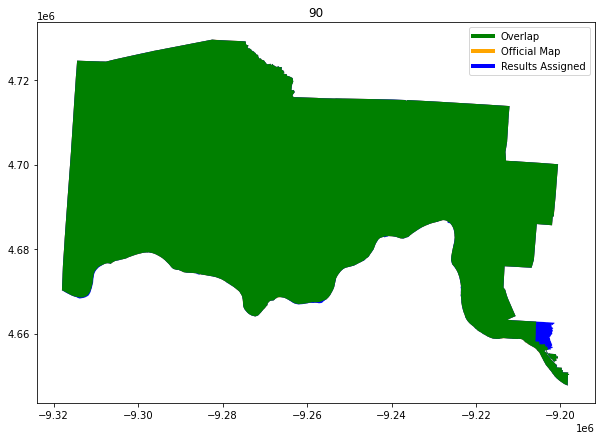

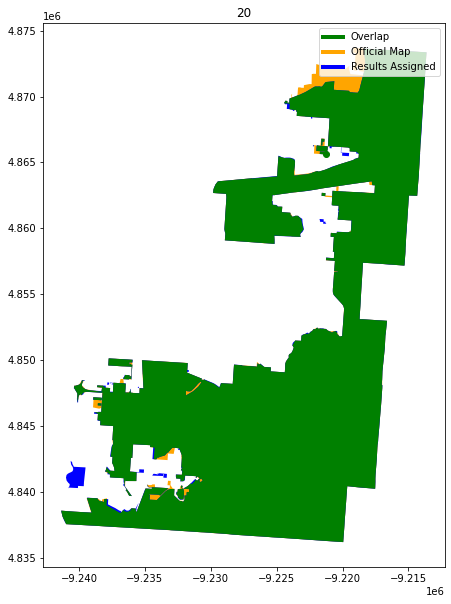

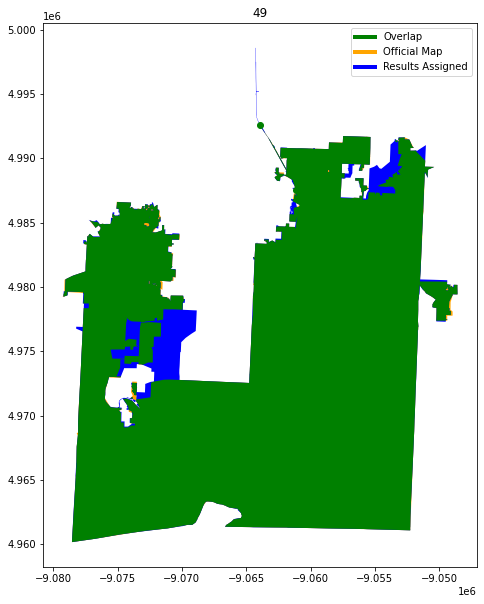

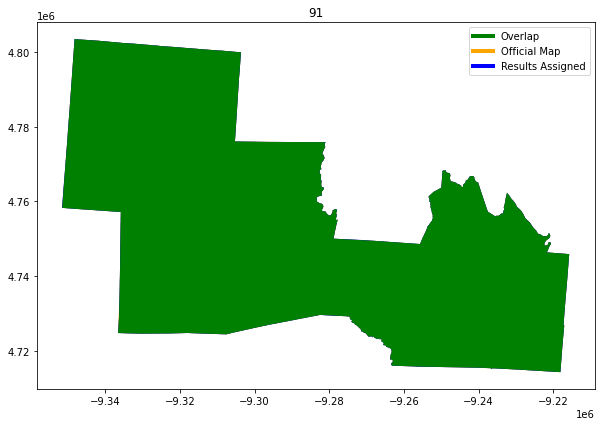

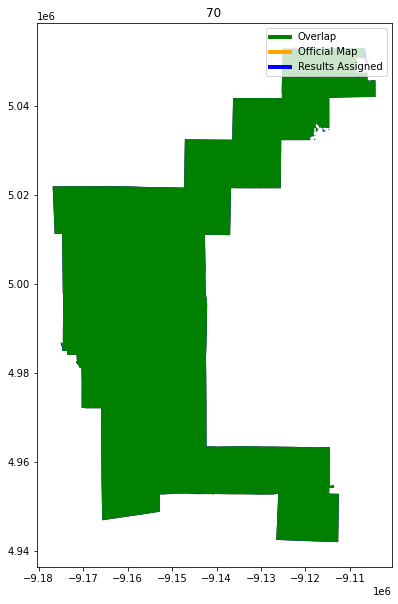

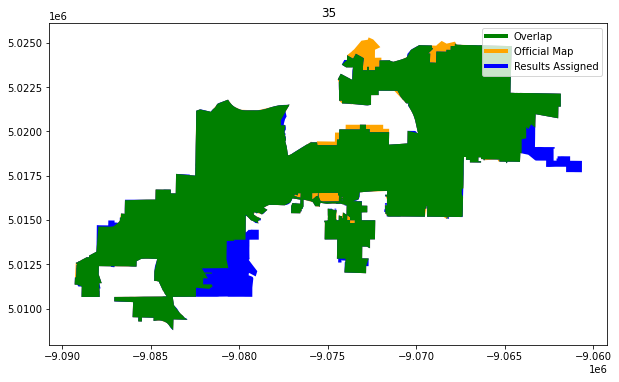

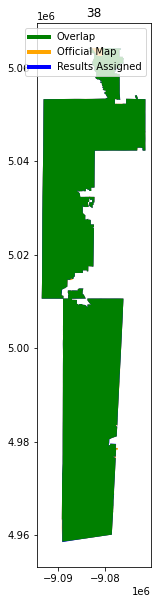

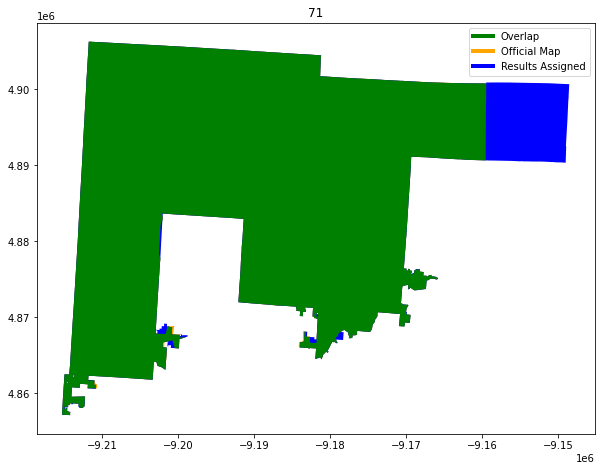

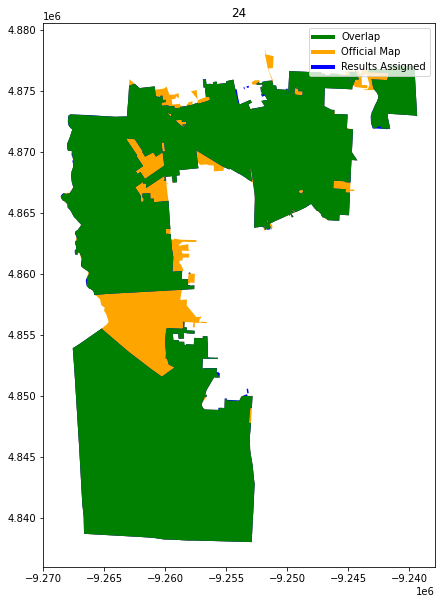

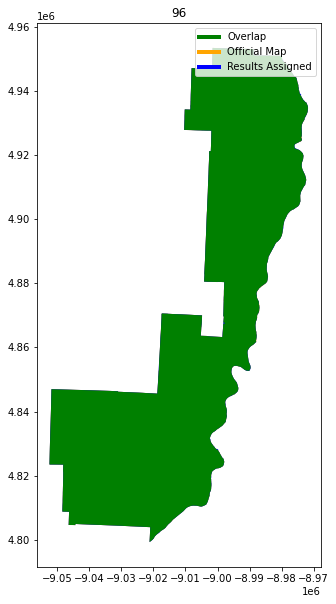

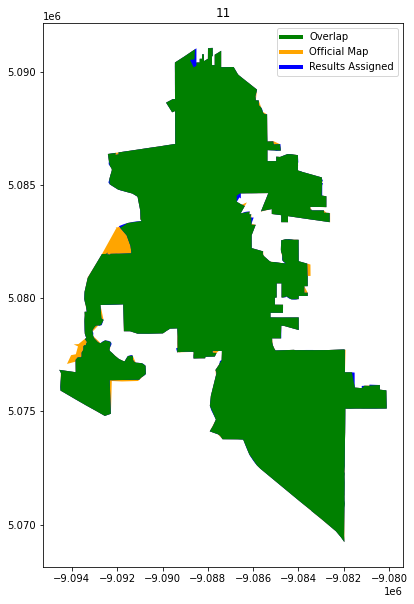

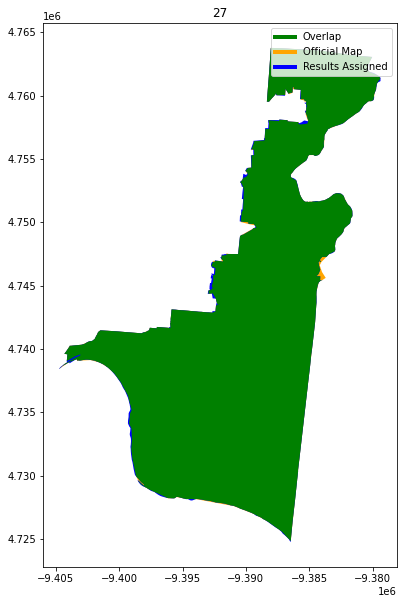

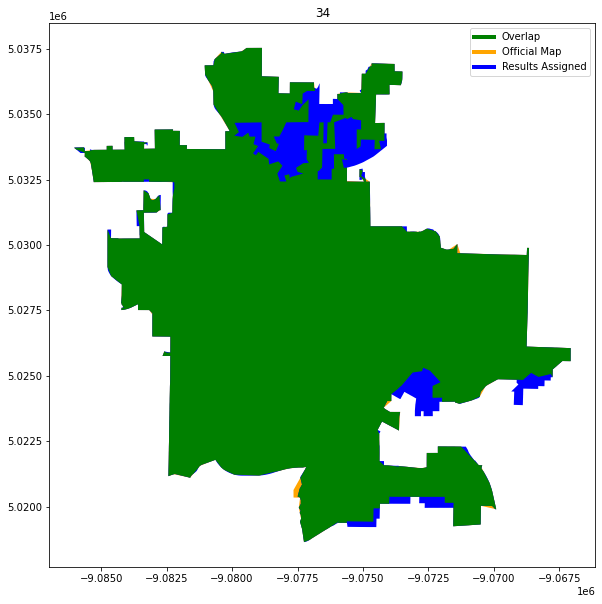

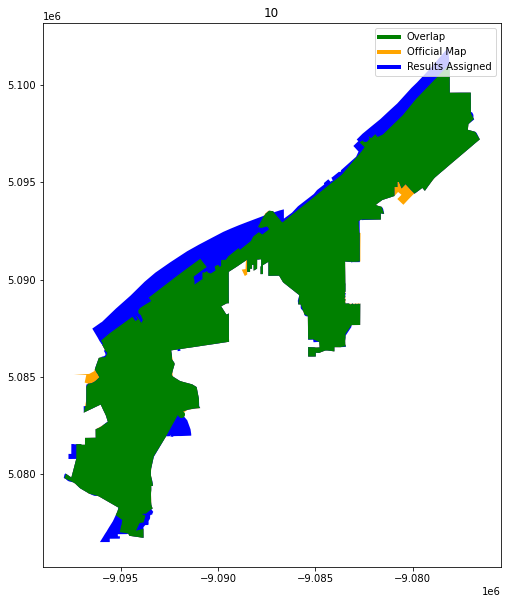

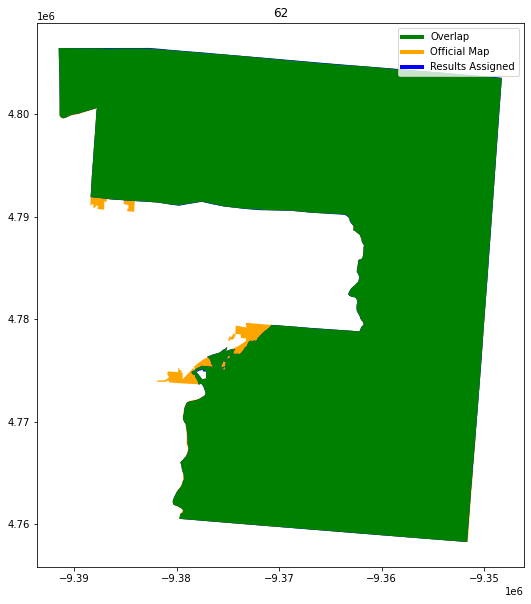

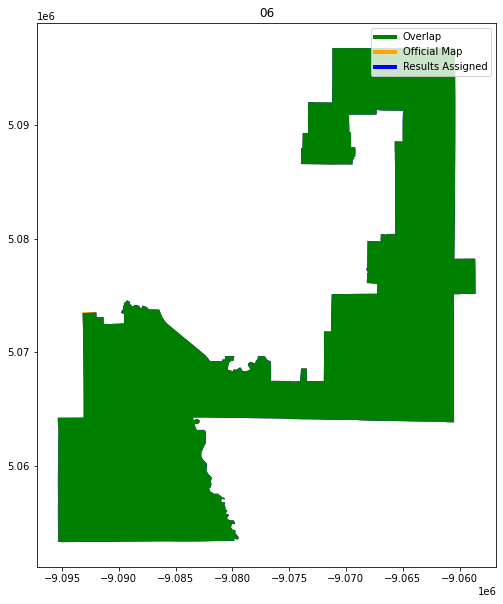

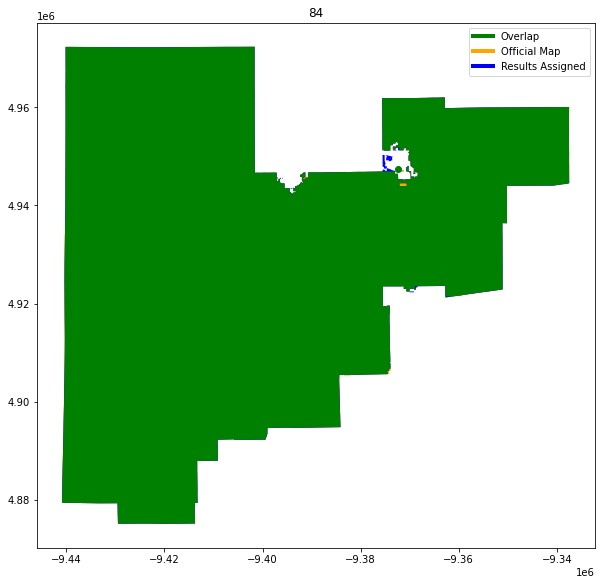

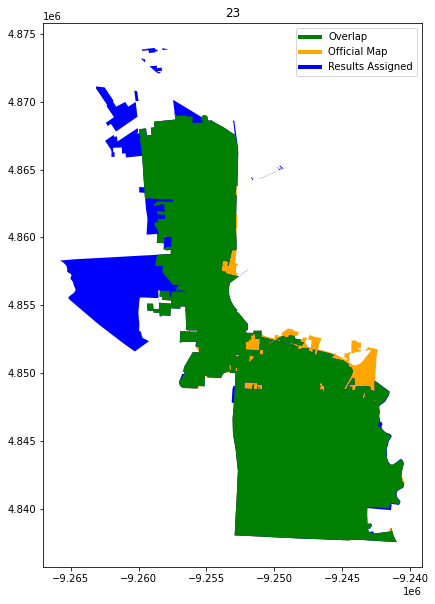

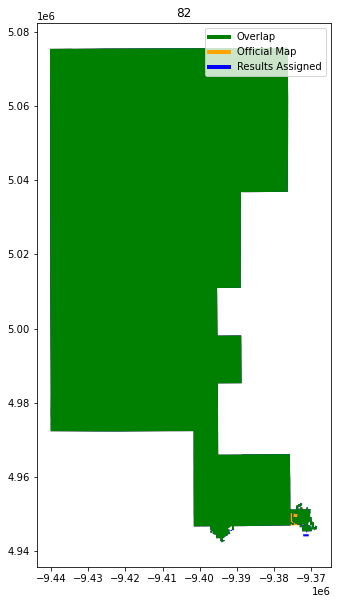

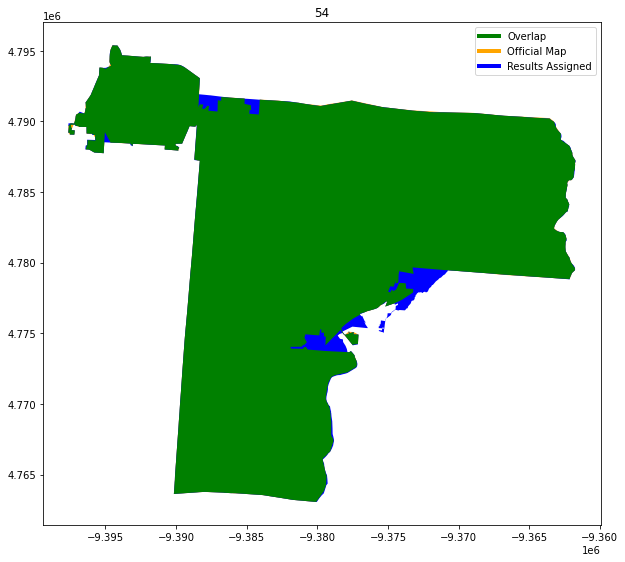

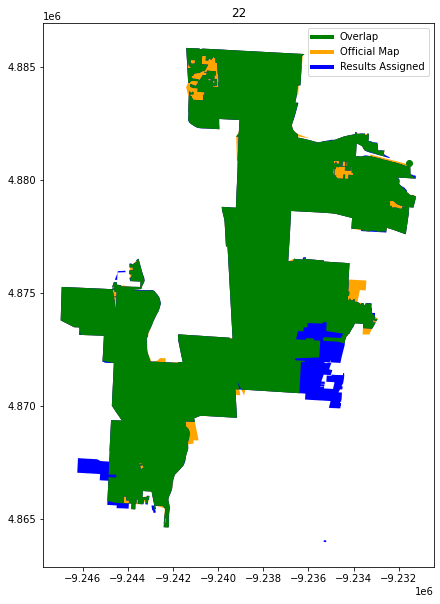

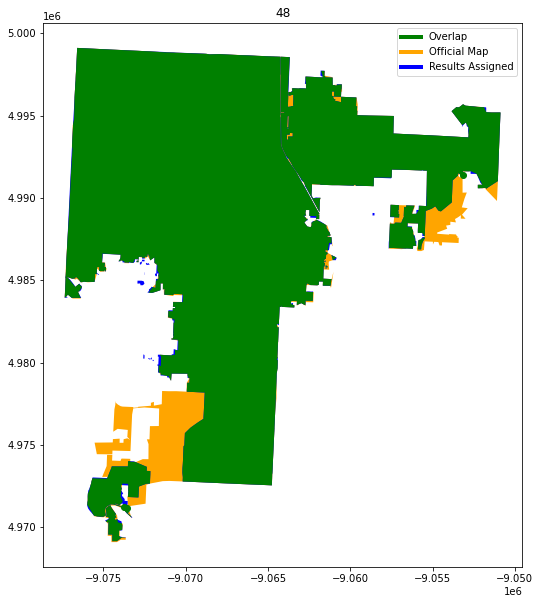

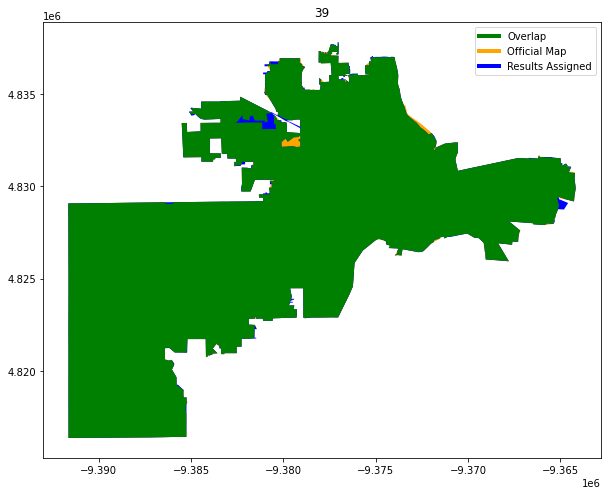

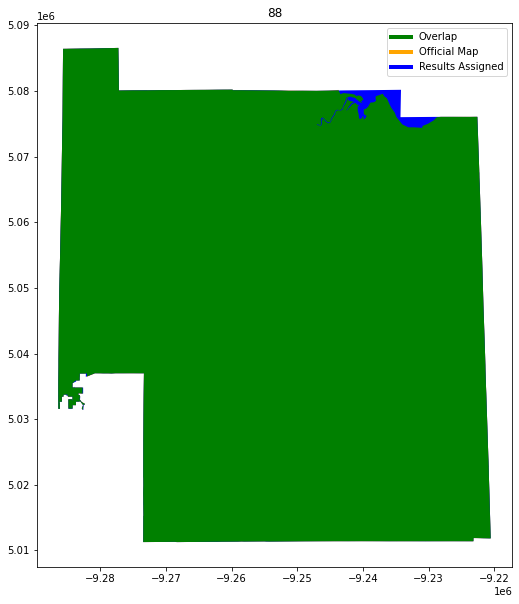

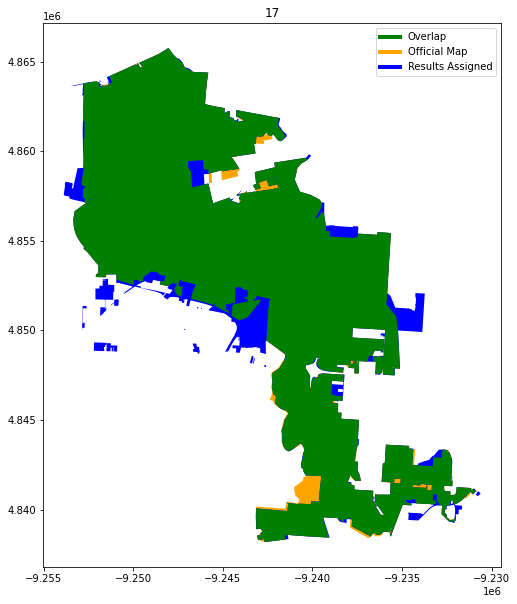

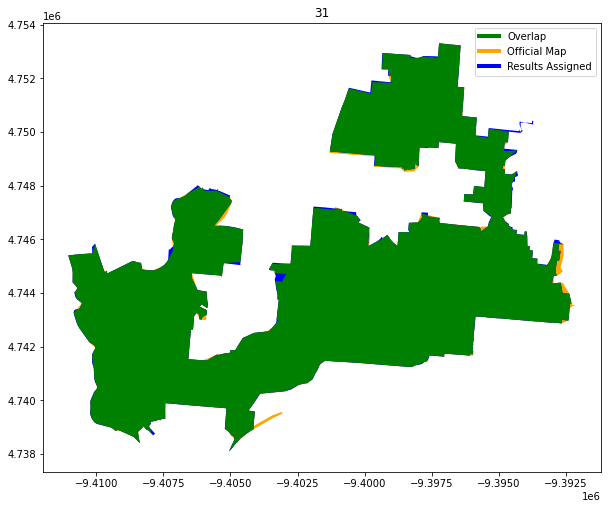

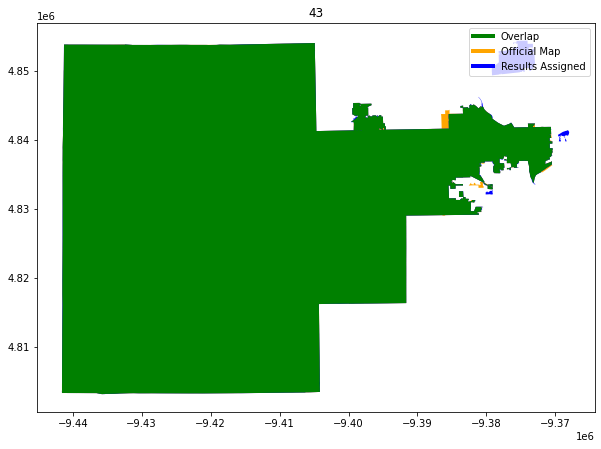

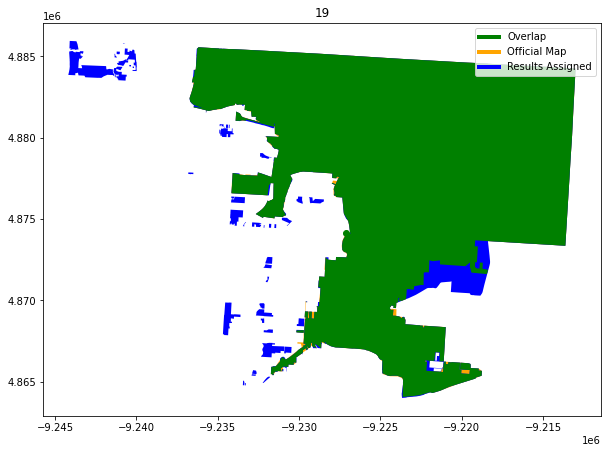

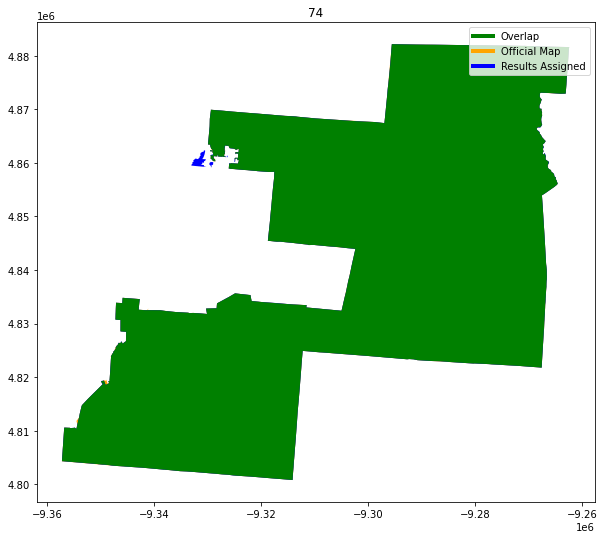

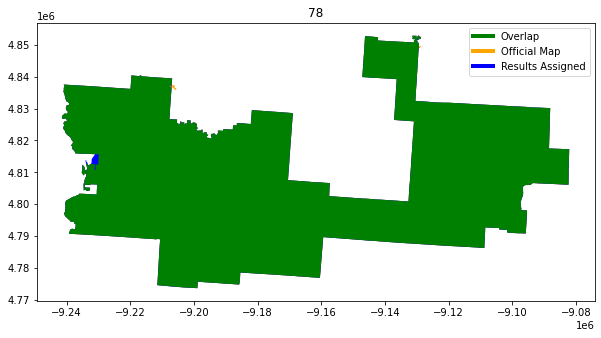

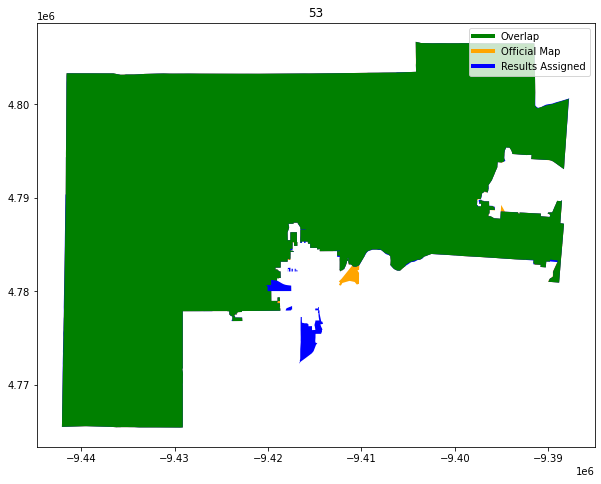

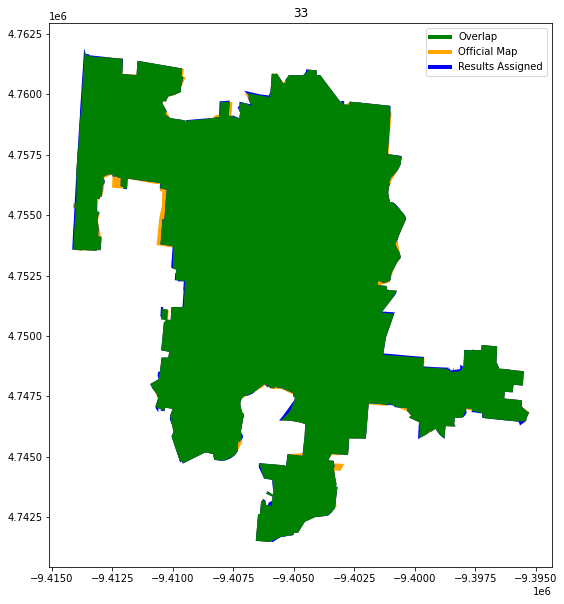

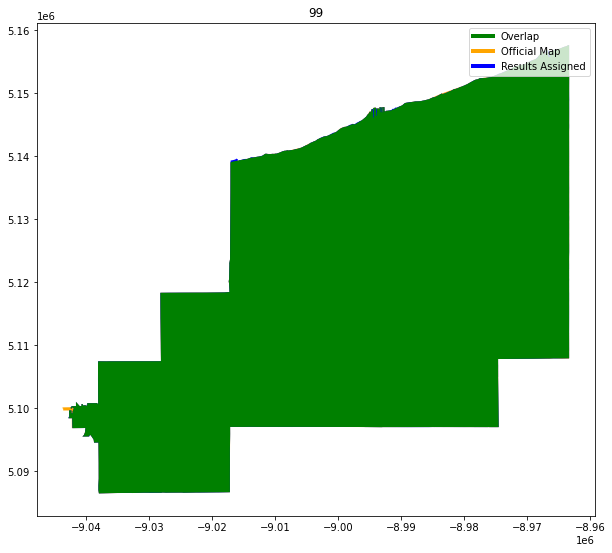

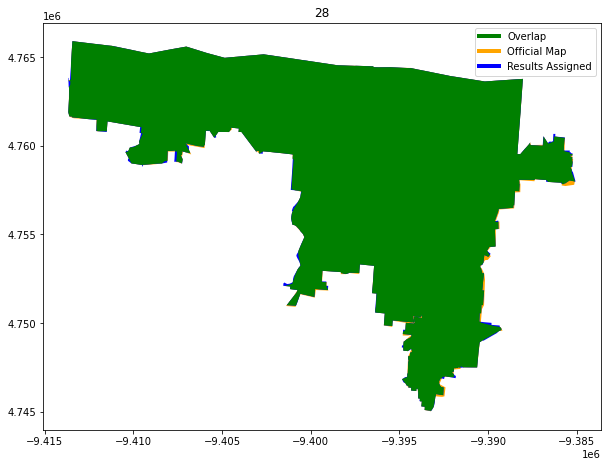

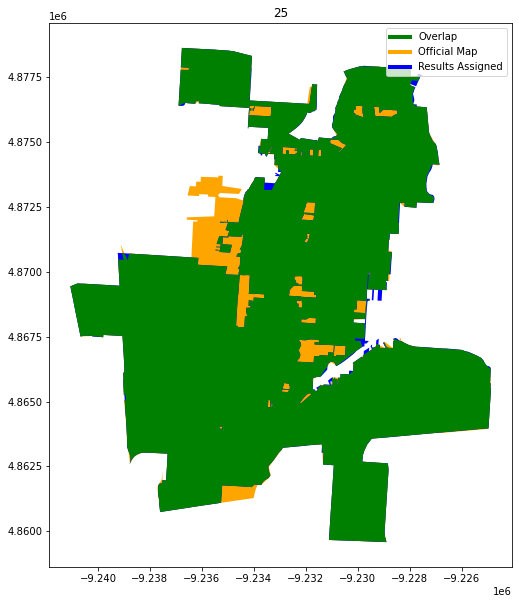

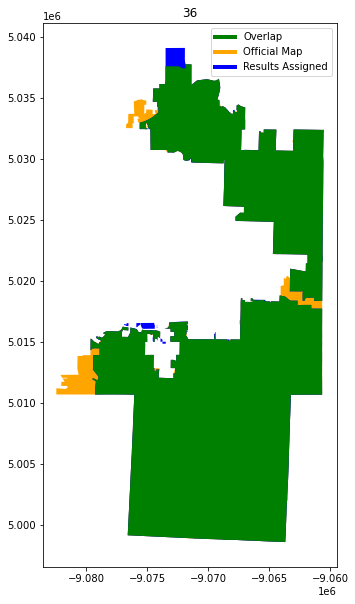

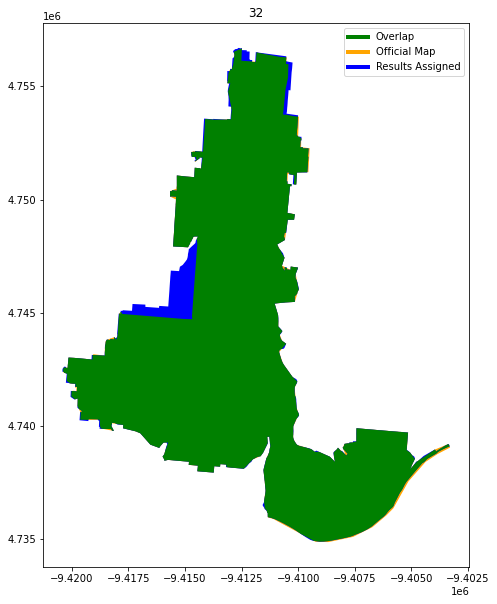

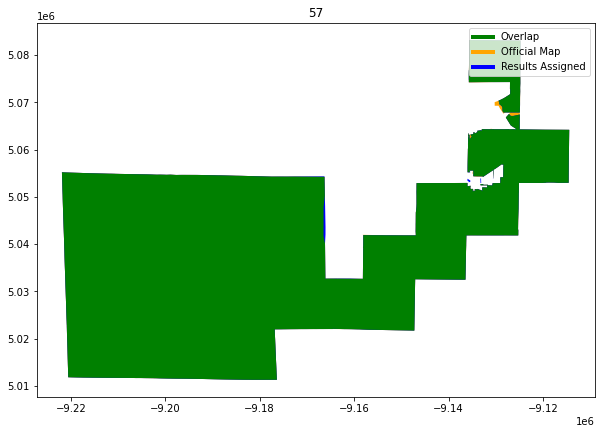

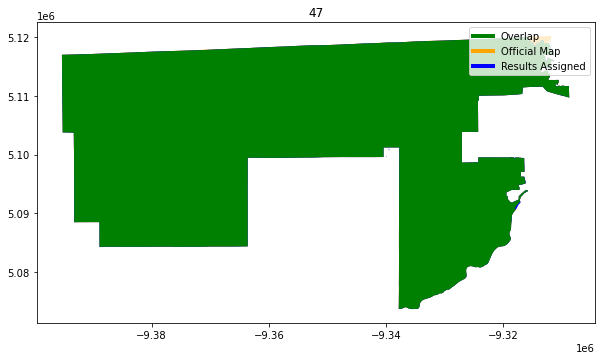

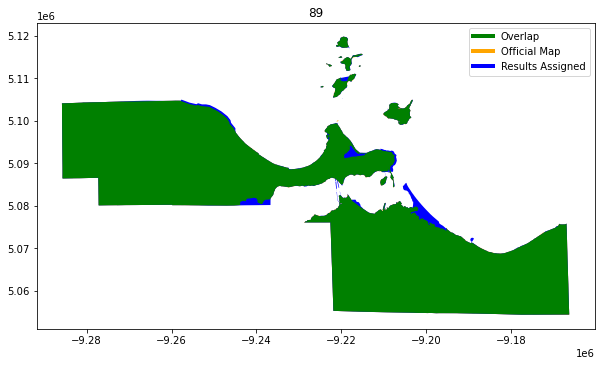

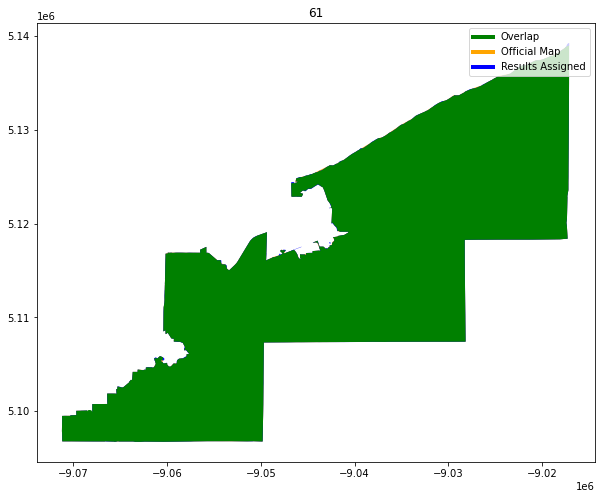

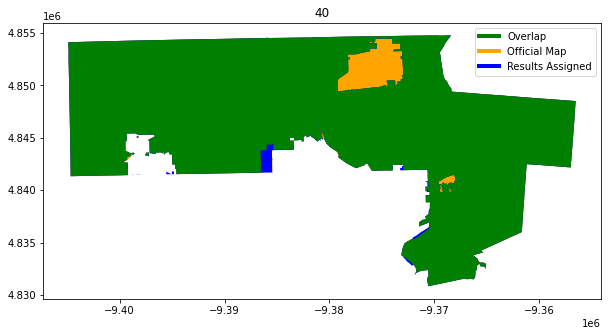

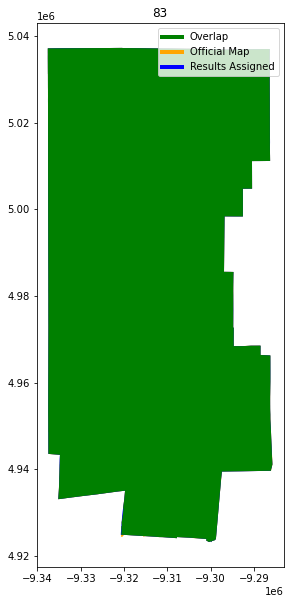

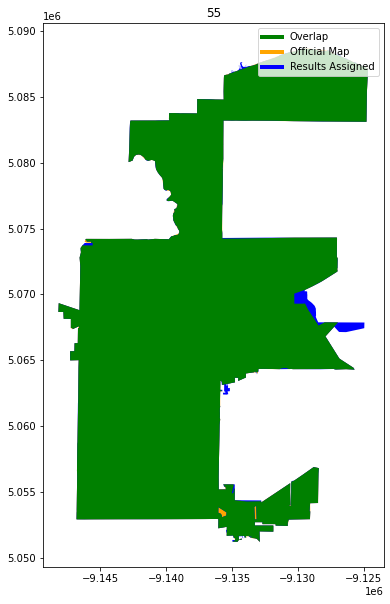

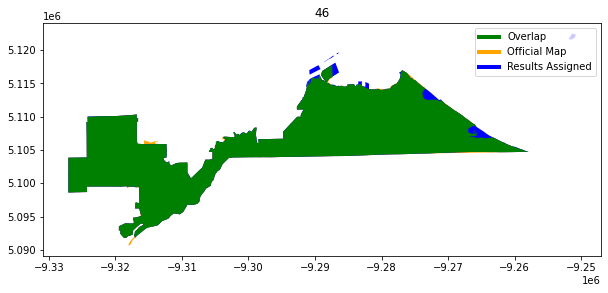

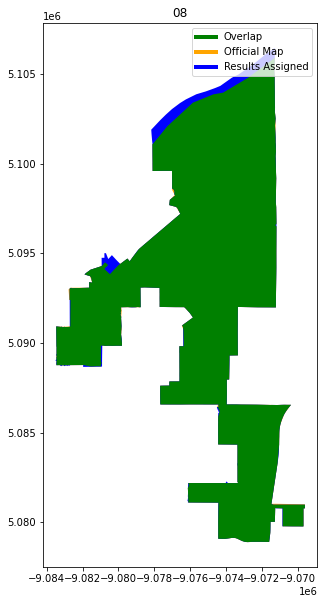

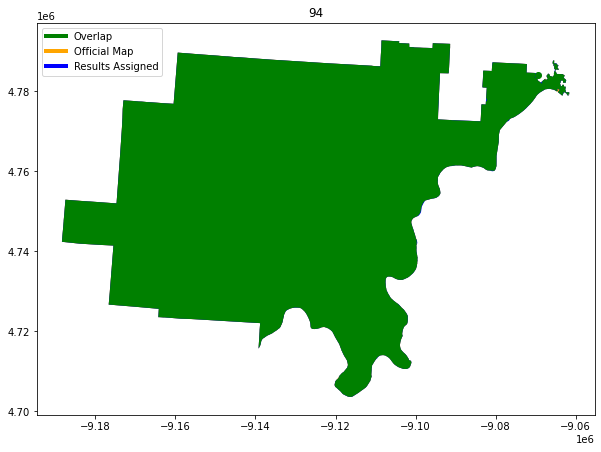

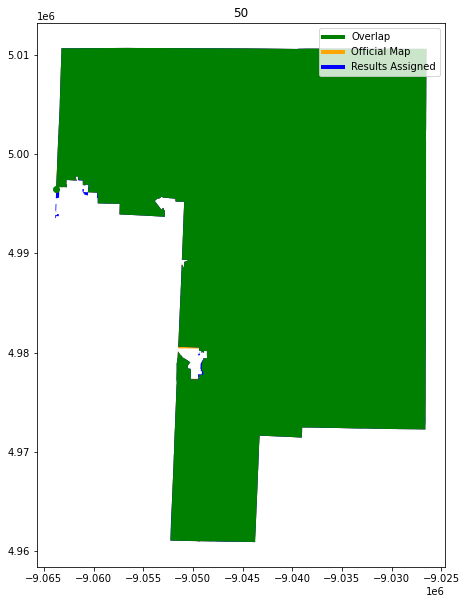

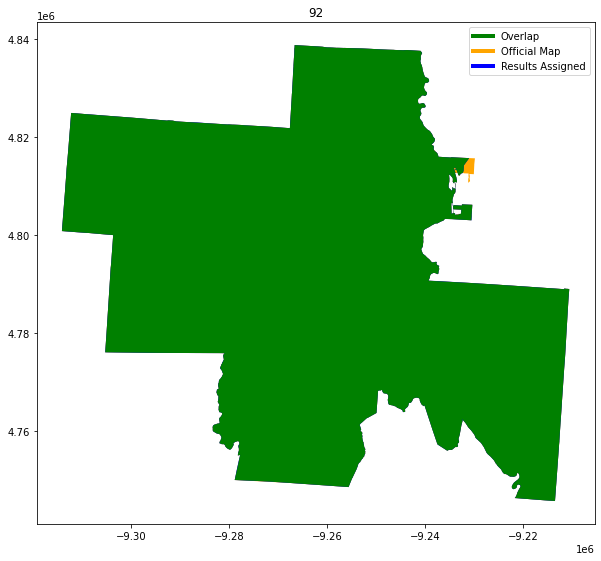

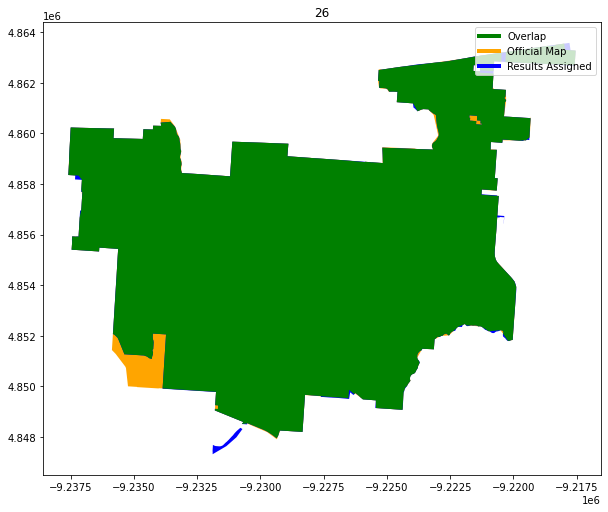

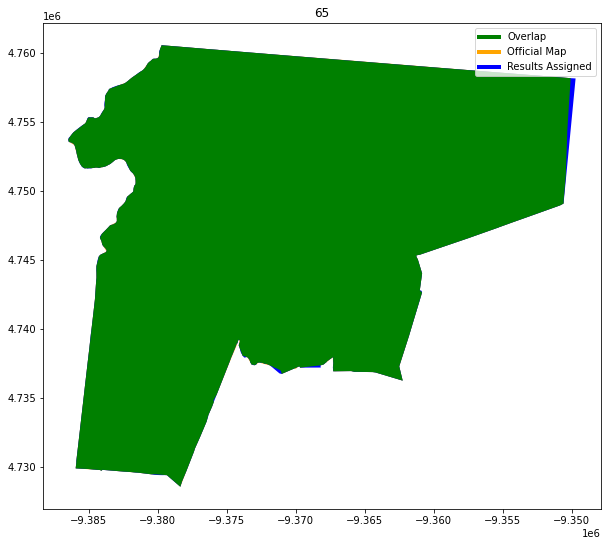

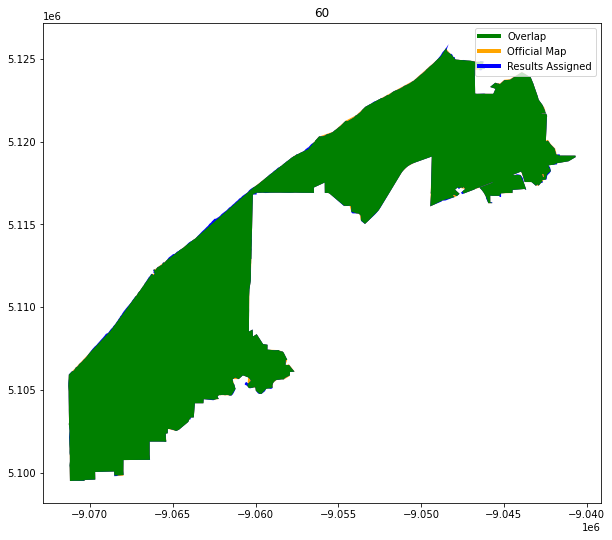

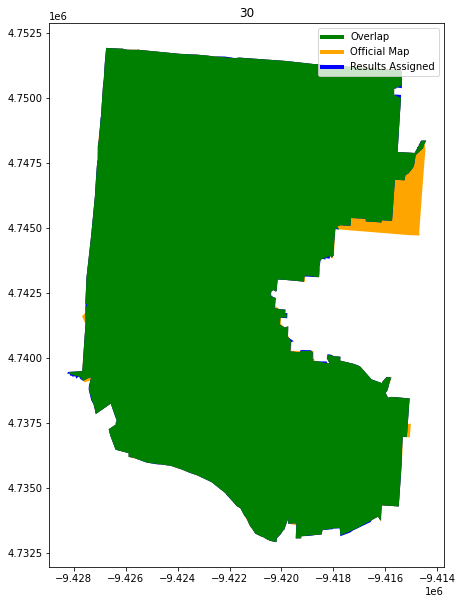

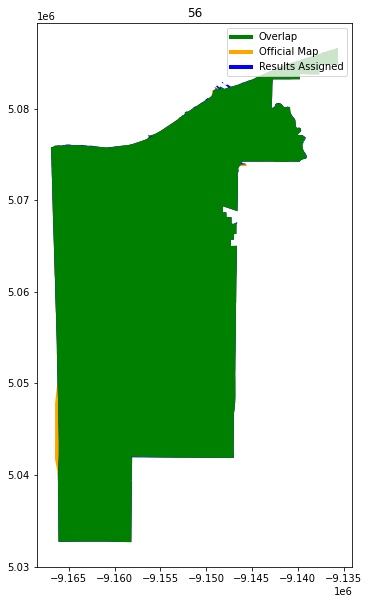

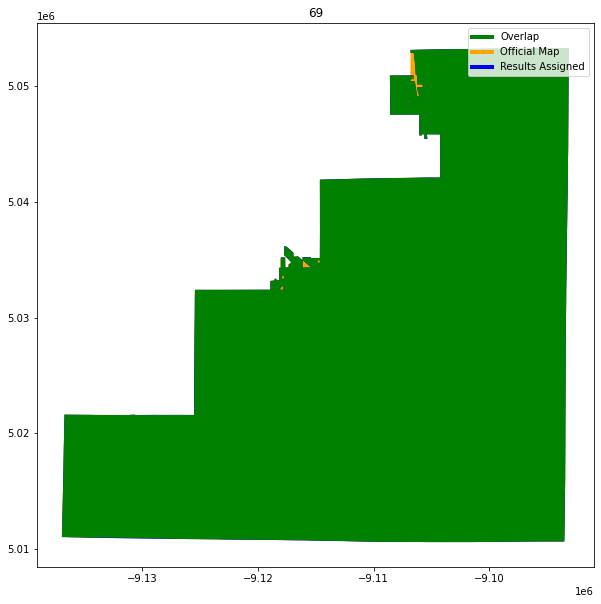

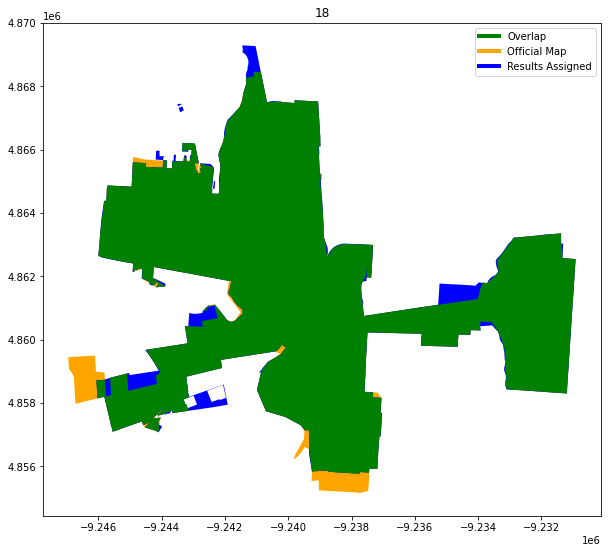

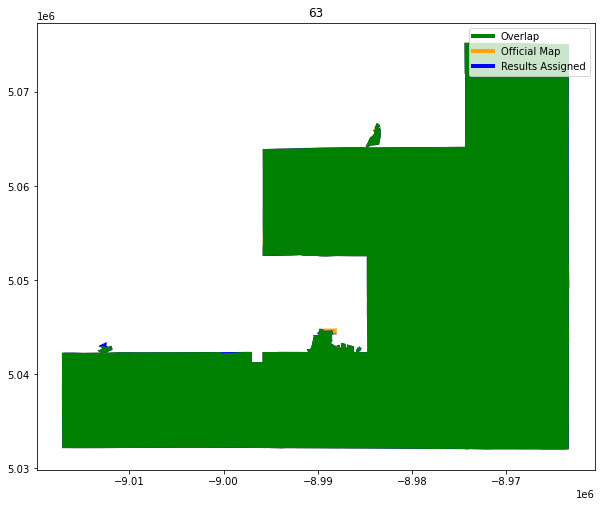

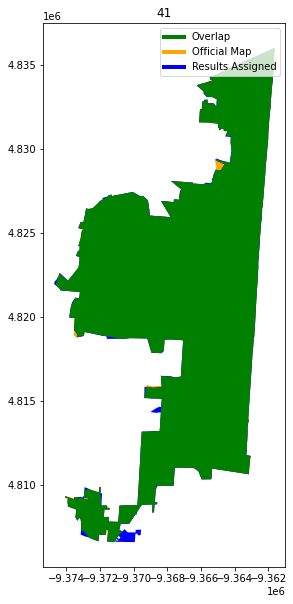

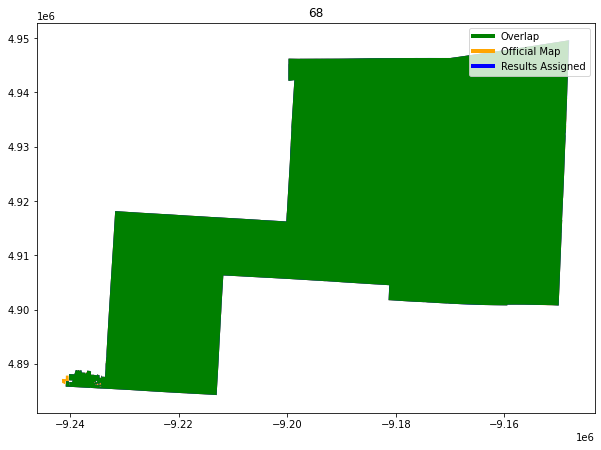

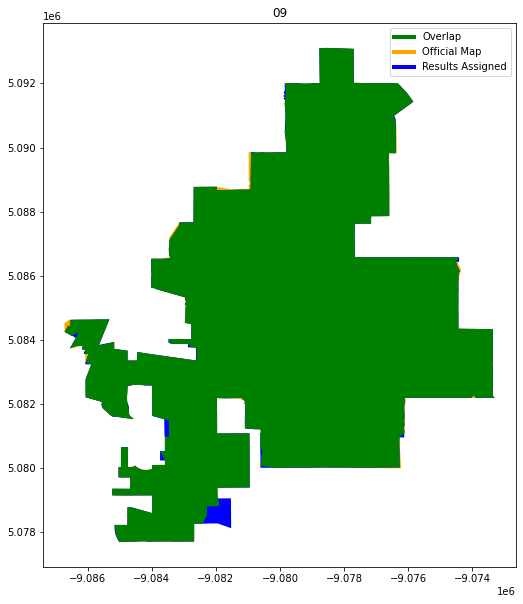

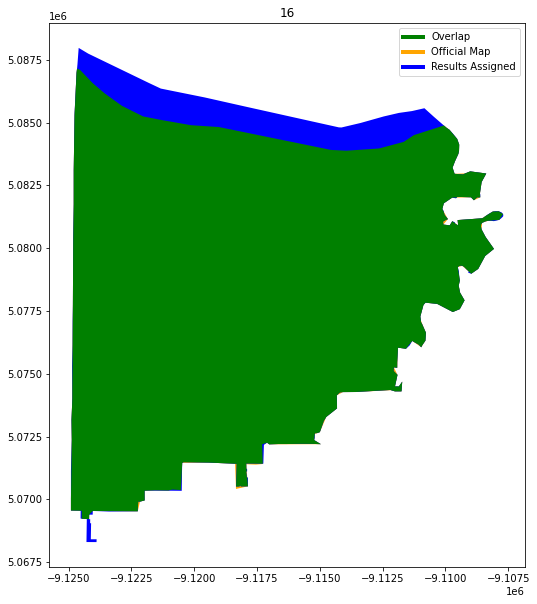

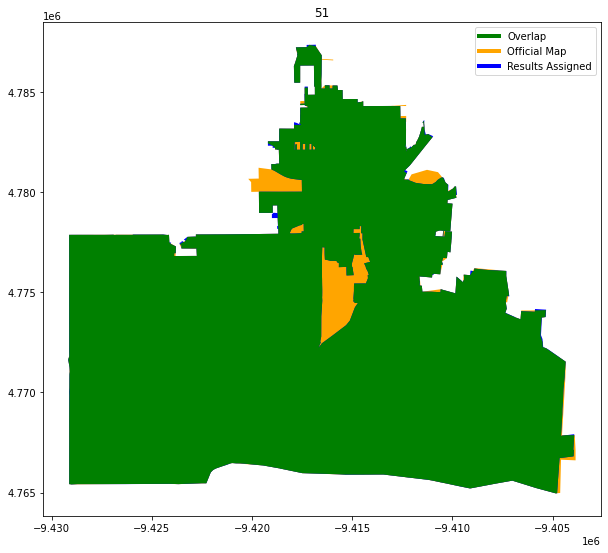

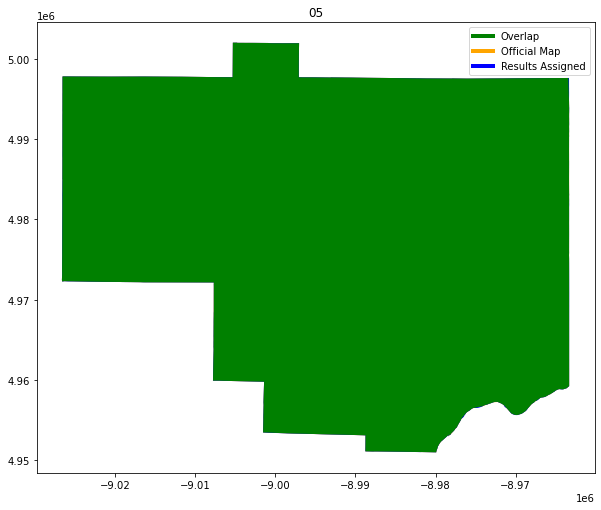

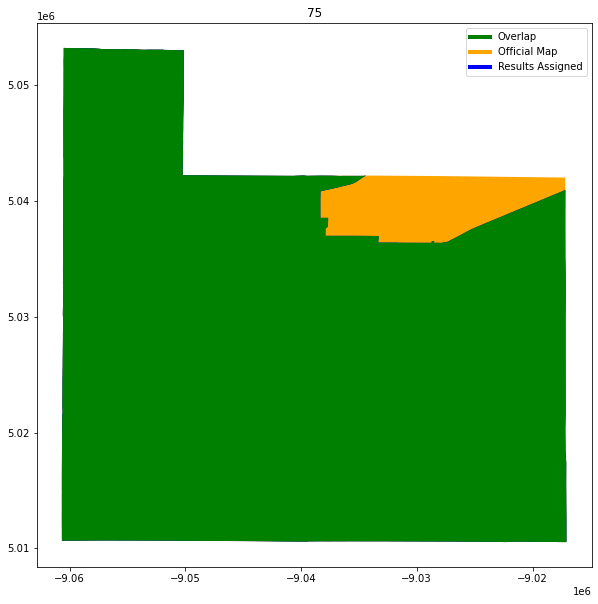

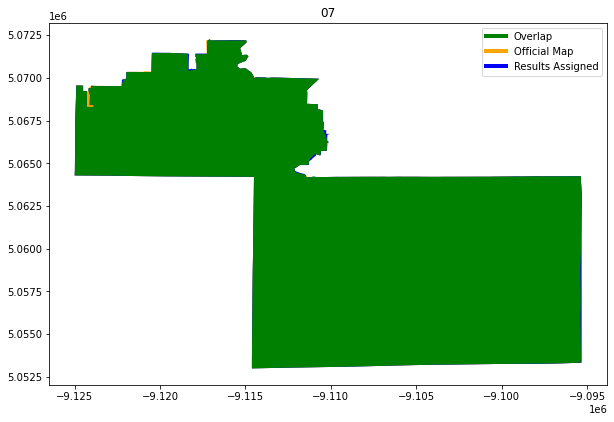

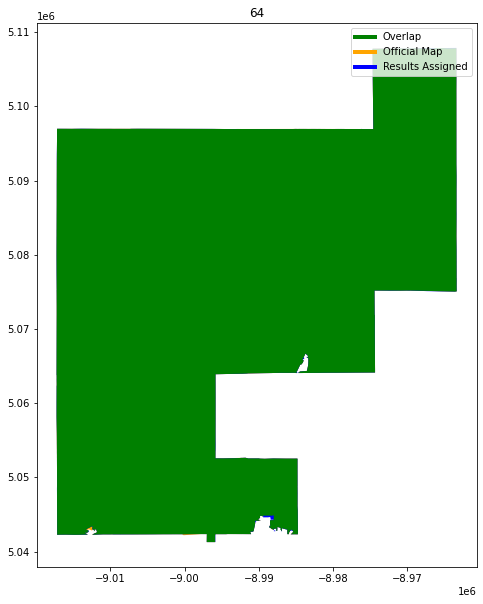

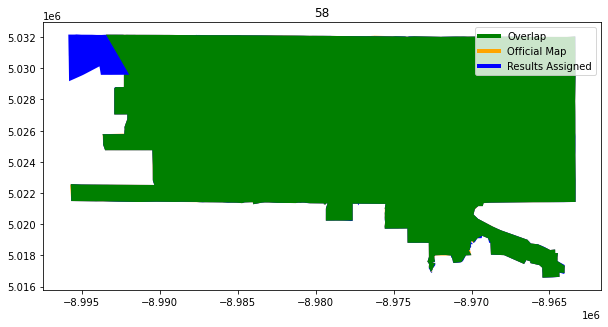

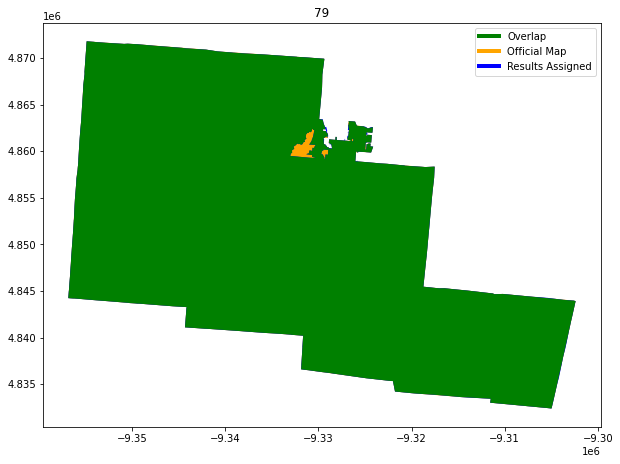

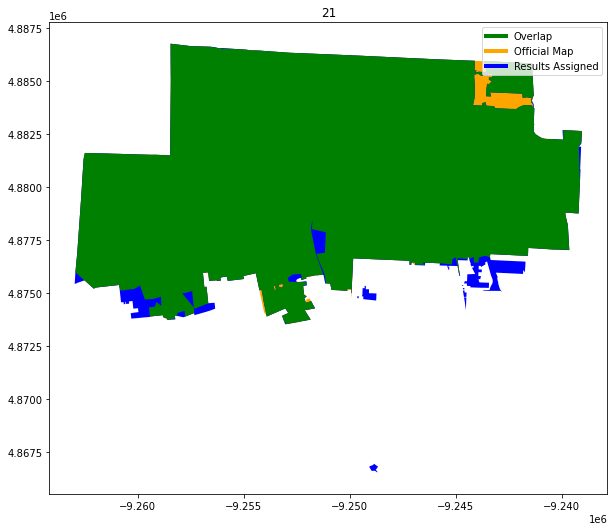

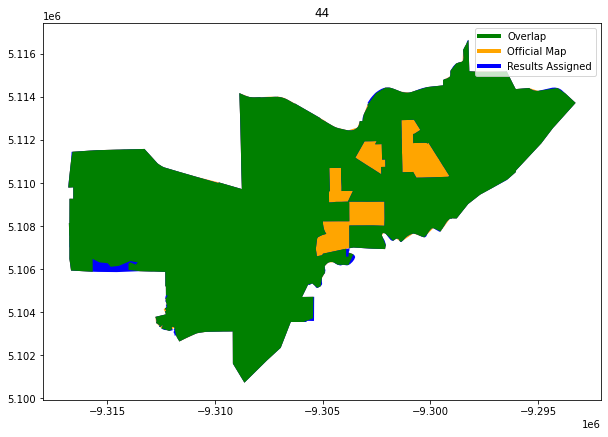

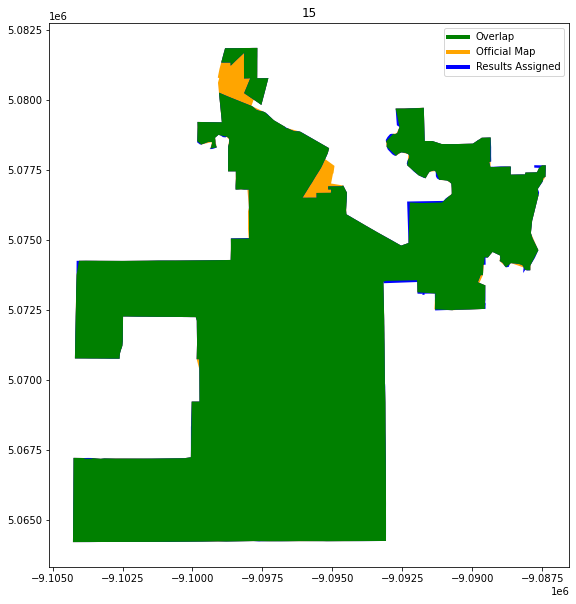

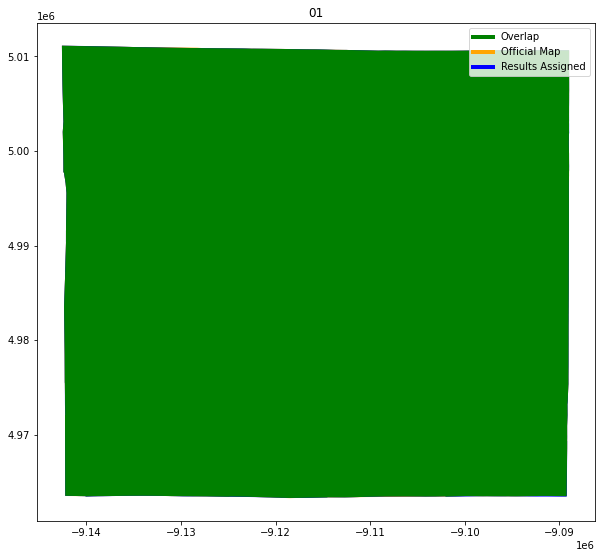

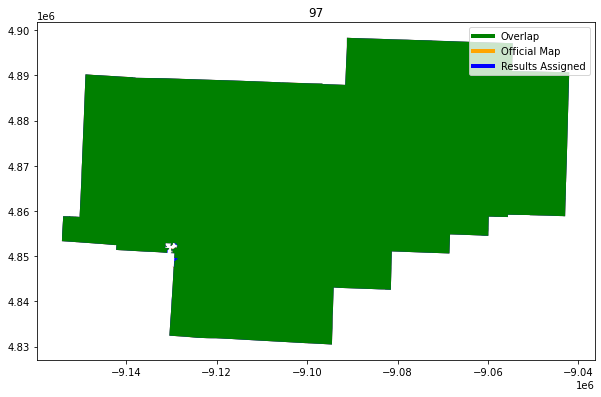

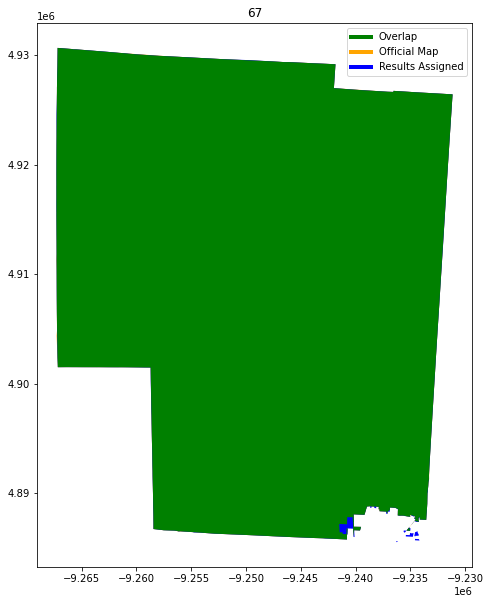

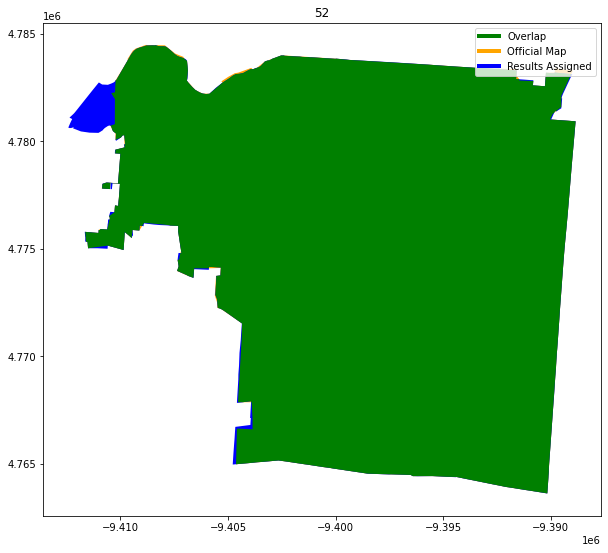

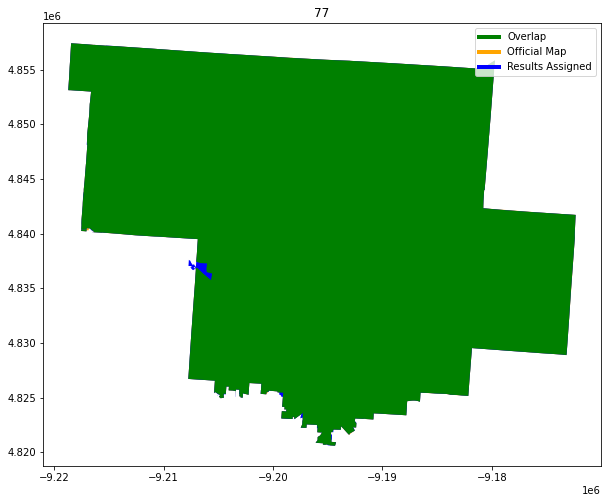

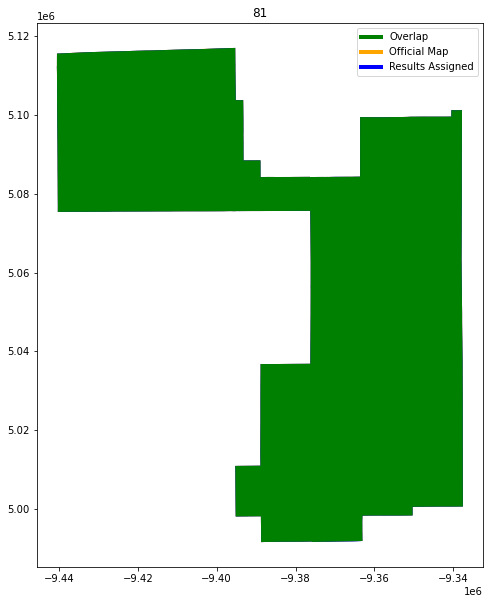

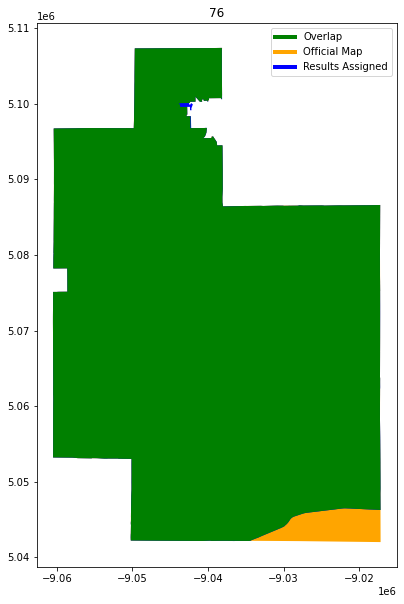

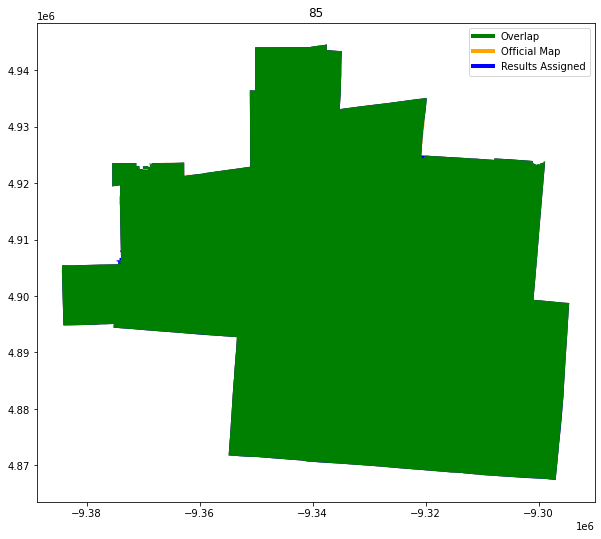

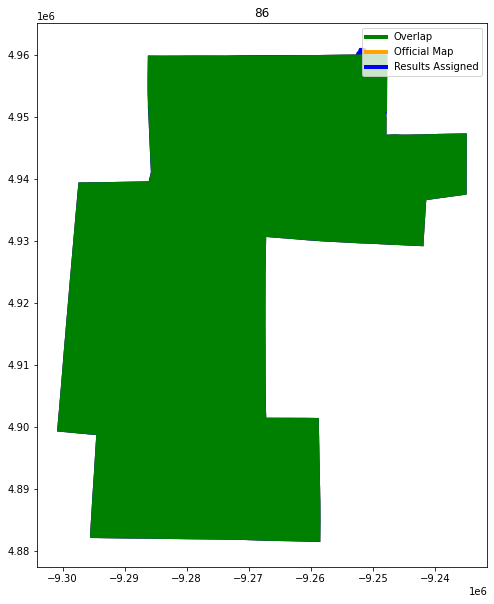

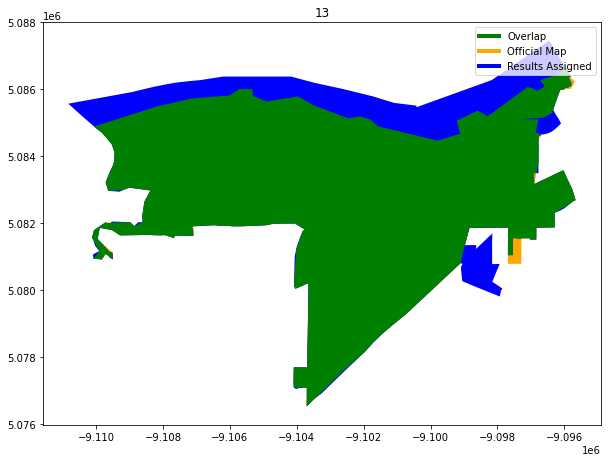

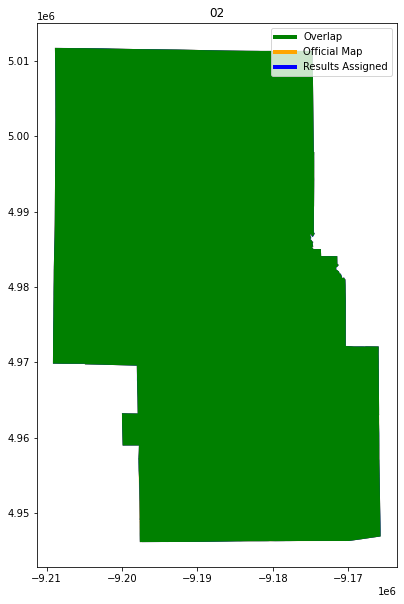

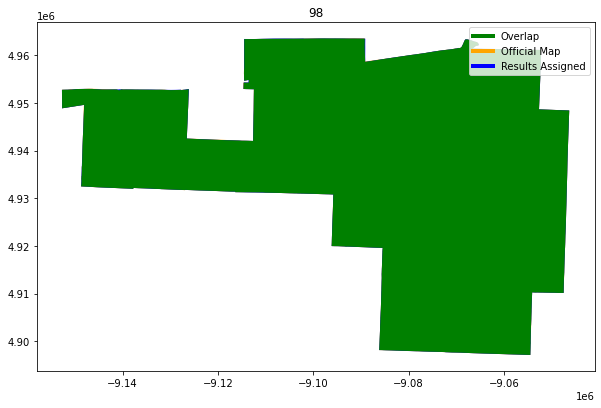

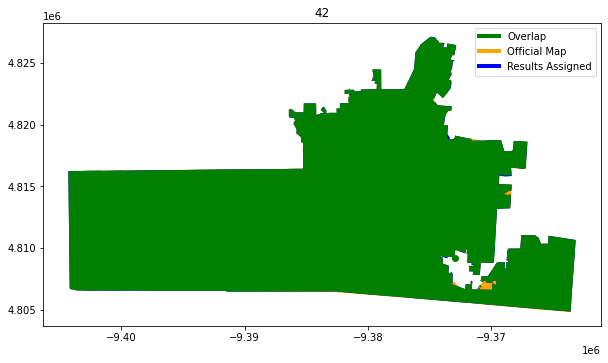

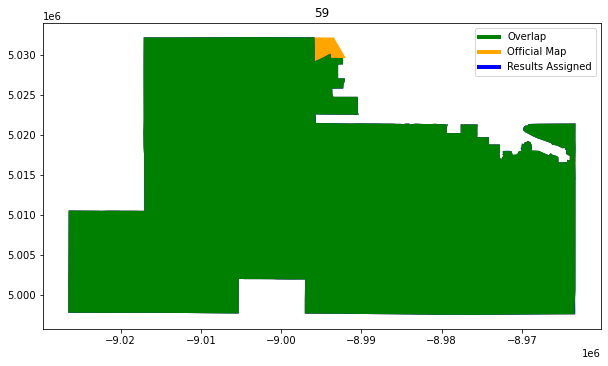

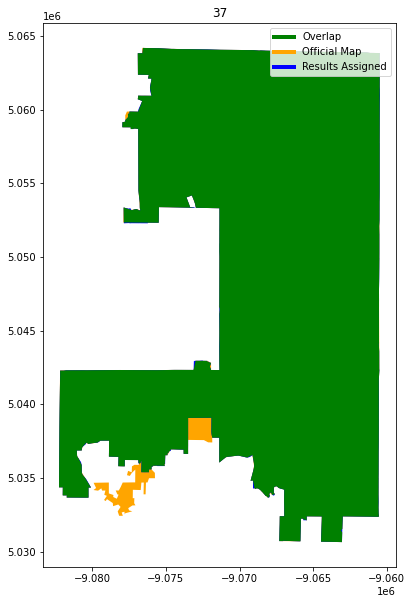

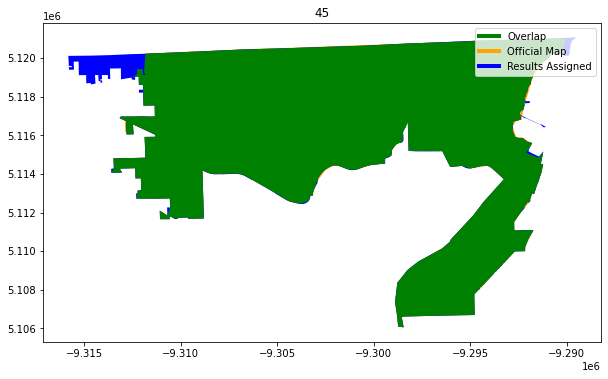

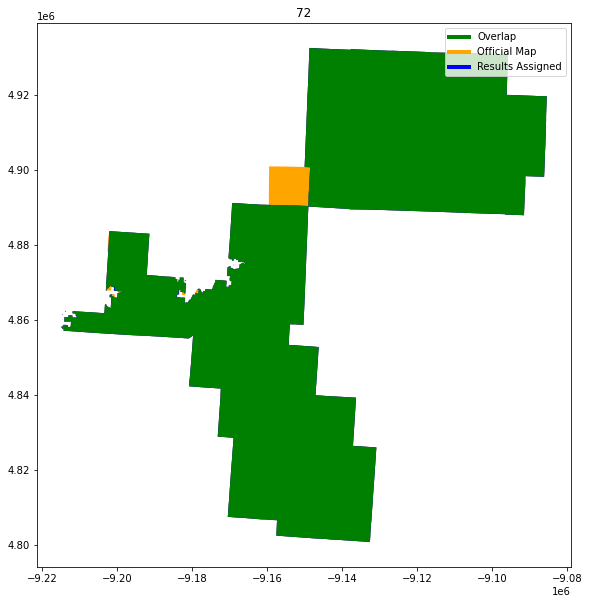

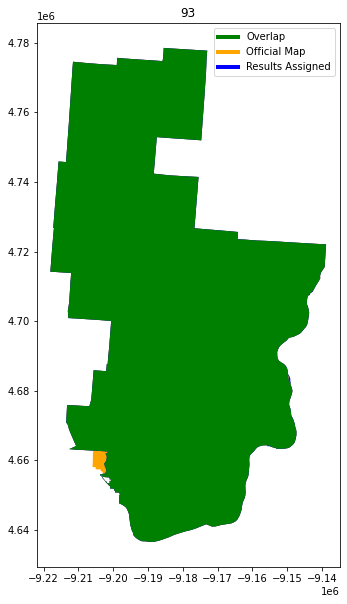

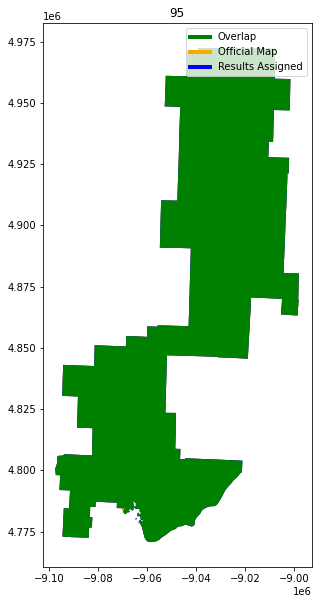

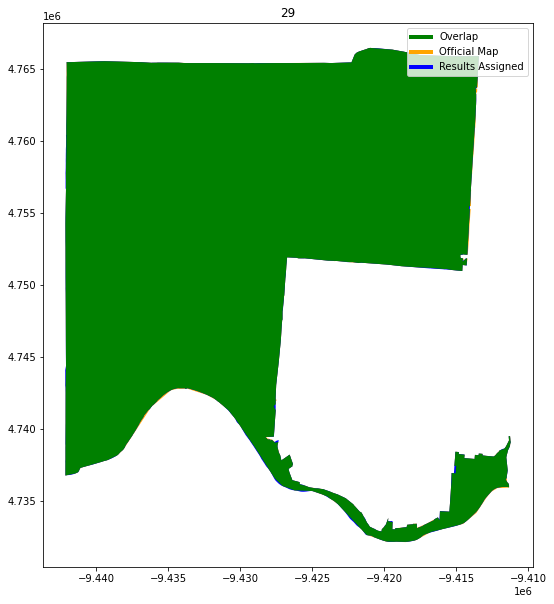

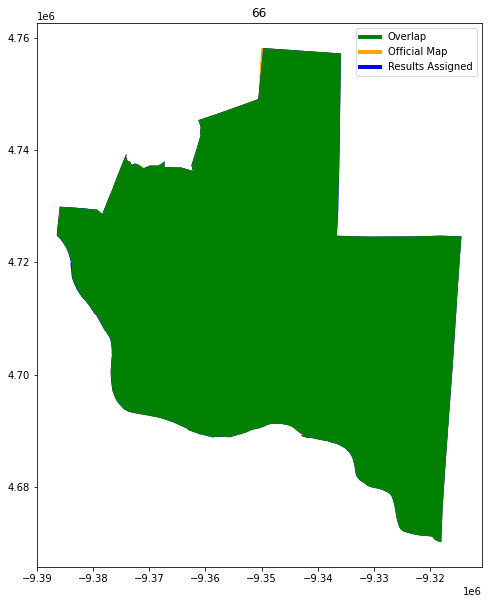

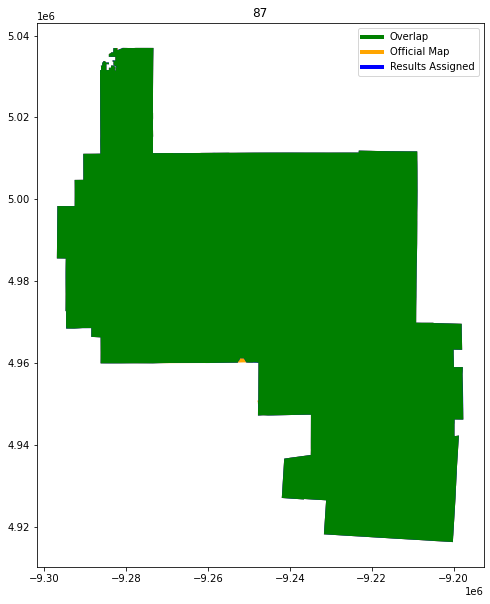

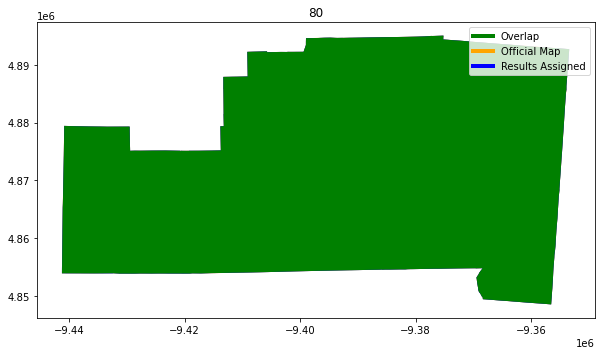

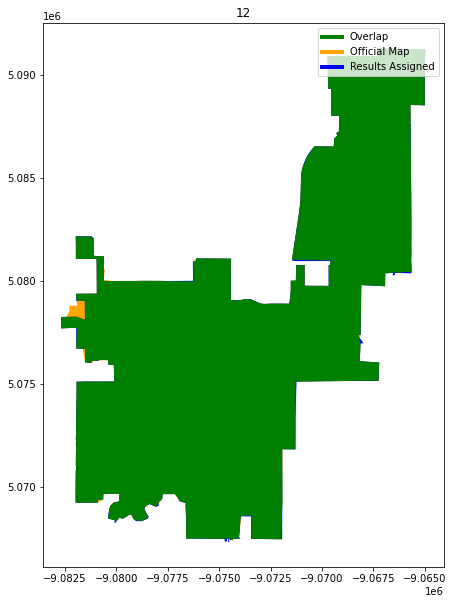

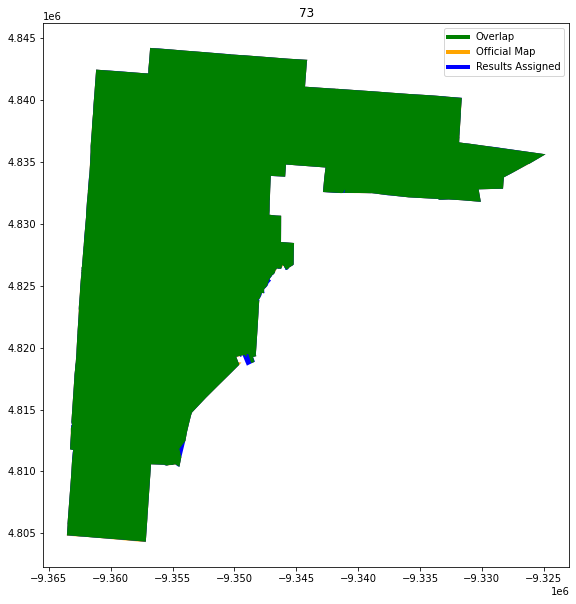

In [69]:
compare_geometries(oh_sll_districts,filtered_results,"Official Map","Results Assigned","SLDL_DIST",area_threshold=.1)

## Sort the columns to match what VEST has

In [70]:
attempt_one = attempt_one[["UNIQUE_ID","COUNTYFP",'STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',"SLDL_DIST"]+
                         final_races+["geometry"]]

In [71]:
if not os.path.exists('./oh_prim_20_prec/'):
    os.mkdir('./oh_prim_20_prec/')

attempt_one.to_file('./oh_prim_20_prec/oh_prim_20_sldl_prec.shp')